In [1]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。


# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
sys.path.append("../ecg-classification/")
# sys.path.append("C:\\Users\\Chen_Lab01\\Documents\\GitHub/ecg-classification")
# from IPython.display import Video

# import cv2
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
# import matplotlib
# matplotlib.use("TkAgg")
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。

# print(sys.path)
from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer



## Data

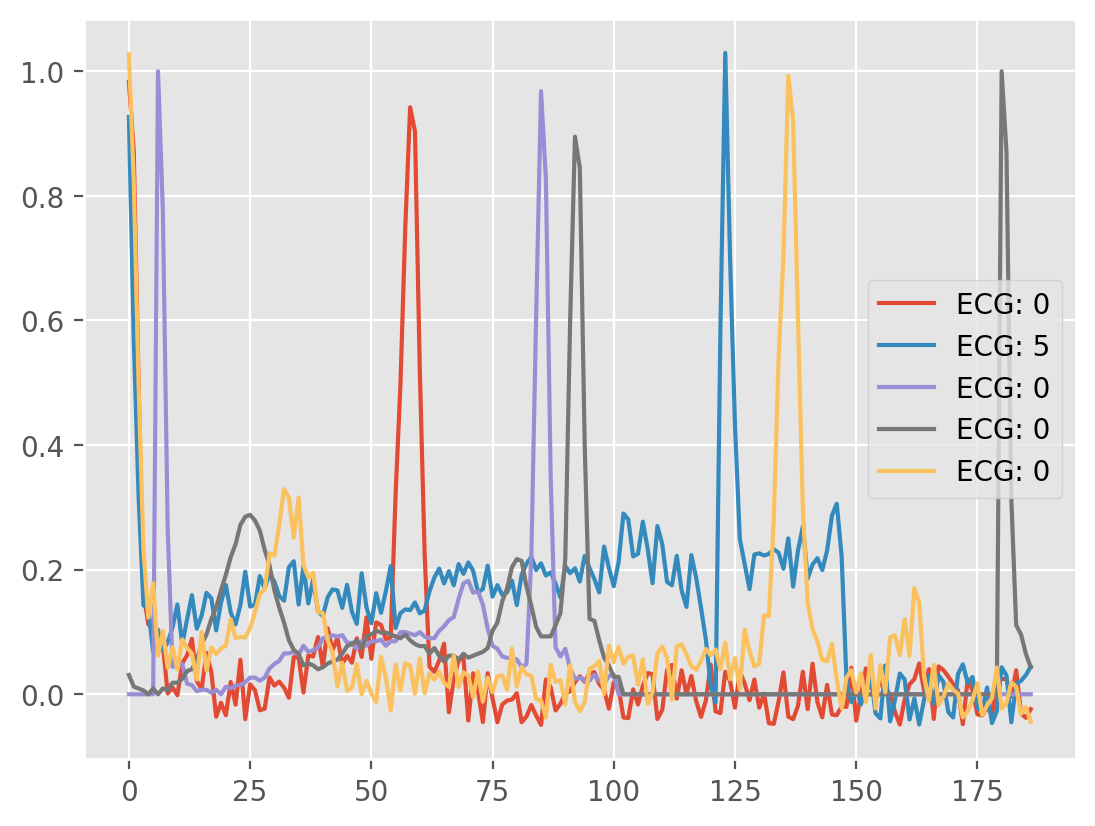

In [2]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

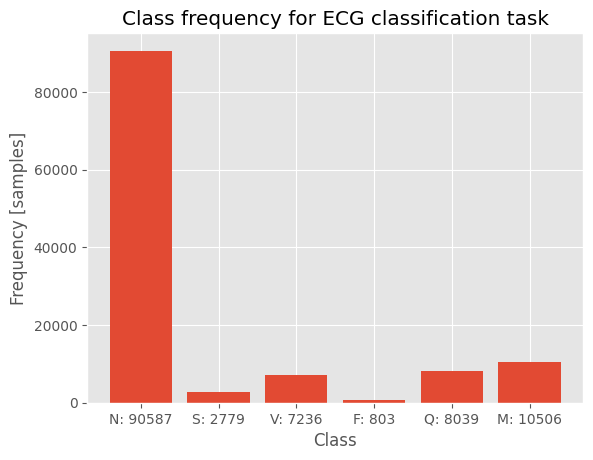

In [3]:
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)
classes = ["N", "S", "V", "F", "Q", "M"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [4]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model

from torchinfo import summary
summary(model, input_size=(2, 187, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [2, 187, 1]               [2, 6]                    36,096                    --
├─LinearEmbedding: 1-1                             [2, 187, 1]               [2, 188, 192]             192                       --
│    └─Linear: 2-1                                 [2, 187, 1]               [2, 187, 192]             384                       --
│    └─LayerNorm: 2-2                              [2, 187, 192]             [2, 187, 192]             384                       --
│    └─GELU: 2-3                                   [2, 187, 192]             [2, 187, 192]             --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [2, 188, 192]  

## Training

TRAINING: 0, loss: 0.28277209401130676. Target: [0, 0, 4, 0, 0, 4, 0, 0], Prediction: [0, 0, 4, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:55<00:00, 25.90it/s]


TRAINING Accuracy: 0.801121175289154
[[69541   369   790   218  1131   421]
 [ 1718   381    67     1    42    14]
 [ 3134    74  1943    48   545    44]
 [  507     1     9   121     2     1]
 [ 1624    18   272     2  4468    47]
 [ 7385    36   237    14   305   428]]
epoch_loss: 9.42887942685251e-05


VALIDATION: 0, loss: 1.7872185707092285. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 750/750 [00:10<00:00, 69.63it/s] 


VALIDATION Accuracy: 0.872208297252655
[[17745   131    62    13     9   157]
 [  229   296    27     0     0     4]
 [  367    29   957    44    13    38]
 [   80     0     1    81     0     0]
 [  174     2     5     0  1391    36]
 [ 1607    13     6     2    10   463]]


TRAINING: 1, loss: 0.4533875286579132. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:52<00:00, 26.63it/s] 


TRAINING Accuracy: 0.8479180335998535
[[68715   691   681   350   364  1669]
 [ 1042   974   119     3    28    57]
 [ 1467   128  3797   101   155   140]
 [  369     0    26   242     0     4]
 [  541    25   110     2  5620   133]
 [ 5959   103   177    23   118  2025]]
epoch_loss: 0.00015117956940910744


TRAINING: 2, loss: 0.4337478578090668. Target: [4, 5, 0, 0, 0, 0, 0, 1], Prediction: [4, 0, 0, 0, 0, 0, 5, 1]: 100%|██████████| 2999/2999 [01:49<00:00, 27.34it/s] 


TRAINING Accuracy: 0.8623707890510559
[[68500   633   662   310   302  2063]
 [  931  1097   108     0    13    74]
 [ 1195   111  4113   103   113   153]
 [  287     5    29   313     0     7]
 [  430    19    89     3  5751   139]
 [ 5035    87   168    20   109  2986]]
epoch_loss: 0.00014463082954620433


VALIDATION: 2, loss: 0.6832261085510254. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 0, 0]: 100%|██████████| 750/750 [00:09<00:00, 76.03it/s]   


VALIDATION Accuracy: 0.8996250033378601
[[16995    30   172    25    97   798]
 [  202   305    10     0     3    36]
 [  174    17  1196    12     8    41]
 [   58     0    23    81     0     0]
 [   64     0     7     0  1510    27]
 [  540     0    14     1    42  1504]]


TRAINING: 3, loss: 0.3205944001674652. Target: [0, 2, 0, 5, 0, 0, 0, 4], Prediction: [0, 2, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:46<00:00, 28.16it/s] 


TRAINING Accuracy: 0.8705401420593262
[[68154   682   674   322   314  2324]
 [  841  1192    91     4    13    82]
 [ 1008    94  4323   108    98   157]
 [  261     1    43   324     0    12]
 [  377    15    76     2  5825   136]
 [ 4334    72   164    29    80  3726]]
epoch_loss: 0.00010690043353366629


TRAINING: 4, loss: 0.8554314970970154. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.14it/s] 


TRAINING Accuracy: 0.8790221810340881
[[68245   610   590   330   263  2432]
 [  808  1249    70     3    12    81]
 [  892   105  4450    96    86   159]
 [  233     6    35   354     0    13]
 [  394    11    71     0  5823   132]
 [ 3819    91   148    22    88  4237]]
epoch_loss: 0.00028523891200300615


VALIDATION: 4, loss: 0.7678159475326538. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 0]: 100%|██████████| 750/750 [00:09<00:00, 76.07it/s]   


VALIDATION Accuracy: 0.9173749685287476
[[17129    89   170   125    55   549]
 [  181   321    29     1     0    24]
 [   98     5  1275    38     6    26]
 [   32     0    12   117     1     0]
 [   53     0     9     0  1525    21]
 [  392     2    28     2    27  1650]]


TRAINING: 5, loss: 0.4011903405189514. Target: [0, 0, 5, 2, 0, 0, 0, 0], Prediction: [0, 0, 5, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.11it/s] 


TRAINING Accuracy: 0.8850241899490356
[[68301   673   612   298   272  2314]
 [  757  1305    71     2    13    75]
 [  859    84  4522    99    74   150]
 [  211     4    29   384     0    13]
 [  361    13    76     0  5854   127]
 [ 3481    88   144    30    94  4568]]
epoch_loss: 0.00013377470507467537


TRAINING: 6, loss: 0.5565544366836548. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.28it/s] 


TRAINING Accuracy: 0.8910990953445435
[[68473   602   554   282   236  2323]
 [  744  1325    68     1    19    66]
 [  796    77  4580    97    87   151]
 [  192     3    34   390     0    22]
 [  329    18    71     0  5884   129]
 [ 3227    75   142    17    79  4865]]
epoch_loss: 0.00018558000556307262


VALIDATION: 6, loss: 0.5633790493011475. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.17it/s]    


VALIDATION Accuracy: 0.9181249737739563
[[17055   212   119    22   224   485]
 [  144   375    14     0     1    22]
 [  108    31  1248    26    13    22]
 [   37     0    13   110     0     2]
 [   23     5     8     0  1545    27]
 [  347    13    13     2    24  1702]]


TRAINING: 7, loss: 0.23540523648262024. Target: [4, 5, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.28it/s] 


TRAINING Accuracy: 0.8937666416168213
[[68427   631   588   284   248  2292]
 [  733  1346    57     2    13    72]
 [  757    69  4621   108    87   146]
 [  206     3    42   377     1    12]
 [  323    12    67     0  5912   117]
 [ 3012    71   150    12    70  5090]]
epoch_loss: 7.849457701988004e-05


TRAINING: 8, loss: 0.2939343750476837. Target: [4, 2, 2, 0, 0, 0, 0, 0], Prediction: [4, 2, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.28it/s] 


TRAINING Accuracy: 0.8968406319618225
[[68570   626   587   297   229  2161]
 [  722  1354    53     2    16    76]
 [  714    67  4657    99    91   160]
 [  197     4    46   377     0    17]
 [  316    14    79     0  5901   121]
 [ 2876    74   149    15    82  5209]]
epoch_loss: 9.801079528098823e-05


VALIDATION: 8, loss: 0.28673288226127625. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.42it/s]  


VALIDATION Accuracy: 0.9310416579246521
[[17344   144    63    35    24   507]
 [  162   366     4     0     1    23]
 [  138    15  1184    61     4    46]
 [   37     0     3   120     0     2]
 [   55     0     5     1  1517    30]
 [  268     5     6     1     7  1814]]


TRAINING: 9, loss: 0.2775469720363617. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.28it/s] 


TRAINING Accuracy: 0.8978722095489502
[[68503   589   545   289   256  2288]
 [  719  1369    57     3    14    61]
 [  717    75  4677    93    86   140]
 [  193     2    48   383     0    15]
 [  307    10    71     0  5936   107]
 [ 2794    68   141    25    78  5299]]
epoch_loss: 9.254650618084751e-05


TRAINING: 10, loss: 0.289607971906662. Target: [4, 0, 0, 0, 0, 5, 0, 0], Prediction: [4, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]   


TRAINING Accuracy: 0.9004042744636536
[[68560   650   572   268   243  2177]
 [  717  1359    66     1    15    65]
 [  698    69  4712    79    83   147]
 [  171     3    41   413     0    13]
 [  296    11    72     0  5948   104]
 [ 2723    66   109    18    71  5418]]
epoch_loss: 9.656818002889696e-05


VALIDATION: 10, loss: 0.34439077973365784. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.48it/s]  


VALIDATION Accuracy: 0.922166645526886
[[16951   172    82    25   156   731]
 [  146   371    12     0     5    22]
 [   97    12  1264    24    14    37]
 [   49     0    12    97     0     4]
 [   22     3     9     0  1550    24]
 [  154    11    10     1    26  1899]]


TRAINING: 11, loss: 0.9482918381690979. Target: [1, 0, 5, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]  


TRAINING Accuracy: 0.9033740162849426
[[68657   621   541   284   231  2136]
 [  695  1402    52     0    13    61]
 [  636    66  4770    84    87   145]
 [  173     2    50   401     1    14]
 [  281     8    71     0  5990    81]
 [ 2635    71   120    24    80  5475]]
epoch_loss: 0.000316202680283127


TRAINING: 12, loss: 1.4423235654830933. Target: [0, 4, 0, 0, 0, 1, 0, 5], Prediction: [0, 4, 0, 0, 0, 5, 0, 5]: 100%|██████████| 2999/2999 [01:46<00:00, 28.28it/s]  


TRAINING Accuracy: 0.9066668152809143
[[68749   578   581   286   212  2064]
 [  677  1421    45     0    11    69]
 [  648    44  4786    91    79   140]
 [  176     4    41   412     0     8]
 [  271     7    68     0  6002    83]
 [ 2499    67   118    12    68  5641]]
epoch_loss: 0.00048093483343884406


VALIDATION: 12, loss: 0.2704901099205017. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.29it/s]   


VALIDATION Accuracy: 0.9142083525657654
[[16734   174    56    31    13  1109]
 [  146   376     5     0     0    29]
 [   95    17  1246    36     5    49]
 [   29     0     9   121     0     3]
 [   67     1     7     0  1508    25]
 [  122     3     4     0    16  1956]]


TRAINING: 13, loss: 1.2693321704864502. Target: [0, 0, 0, 0, 0, 1, 0, 0], Prediction: [0, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]  


TRAINING Accuracy: 0.9070523381233215
[[68753   642   533   273   234  2035]
 [  685  1408    57     1    11    61]
 [  624    62  4821    84    63   134]
 [  166     4    40   424     1     6]
 [  282     9    64     0  5981    95]
 [ 2478    77   116    16    57  5661]]
epoch_loss: 0.00042325180743129384


TRAINING: 14, loss: 0.10778388381004333. Target: [0, 0, 0, 0, 0, 5, 2, 0], Prediction: [0, 0, 0, 0, 0, 5, 2, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.28it/s] 


TRAINING Accuracy: 0.910668134689331
[[68853   598   534   240   212  2033]
 [  680  1429    47     0    12    55]
 [  615    53  4840    85    70   125]
 [  158     2    45   423     1    12]
 [  269     7    63     0  6007    85]
 [ 2327    57   106     6    66  5843]]
epoch_loss: 3.593994125043126e-05


VALIDATION: 14, loss: 0.4578200876712799. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.35it/s]   


VALIDATION Accuracy: 0.9465000033378601
[[17645    80    98    66    38   190]
 [  168   353    17     0     7    11]
 [   80     3  1310    31     7    17]
 [   29     1    17   113     0     2]
 [   51     0     9     0  1528    20]
 [  303     2    19     1     9  1767]]


TRAINING: 15, loss: 0.15059685707092285. Target: [0, 4, 2, 0, 0, 0, 0, 4], Prediction: [0, 4, 2, 0, 0, 0, 3, 4]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.9098137021064758
[[68773   598   569   268   231  2031]
 [  676  1435    48     2    10    52]
 [  632    60  4804    83    78   131]
 [  174     2    40   413     1    11]
 [  274     4    74     0  5999    80]
 [ 2254    62   108    21    71  5889]]
epoch_loss: 5.021569092061449e-05


TRAINING: 16, loss: 0.18198300898075104. Target: [5, 0, 4, 5, 0, 0, 2, 5], Prediction: [5, 0, 4, 5, 0, 0, 2, 5]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.912554144859314
[[68895   585   516   257   232  1985]
 [  653  1449    47     3    15    56]
 [  613    48  4853    95    62   117]
 [  160     1    40   427     1    12]
 [  260     9    62     0  6026    74]
 [ 2224    65   113     9    68  5926]]
epoch_loss: 6.068123007027377e-05


VALIDATION: 16, loss: 0.5362427234649658. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.24it/s]   


VALIDATION Accuracy: 0.949874997138977
[[17699    55    58    46    13   246]
 [  188   352     4     2     3     7]
 [   99     5  1291    34     5    14]
 [   29     0    10   122     0     1]
 [   68     0     7     0  1523    10]
 [  268     0     7     0    16  1810]]


TRAINING: 17, loss: 0.1293371617794037. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.9145861268043518
[[69062   568   486   247   197  1910]
 [  662  1449    43     1     9    59]
 [  569    53  4893    87    62   124]
 [  156     1    51   420     0    13]
 [  260     9    67     0  6012    83]
 [ 2208    55   114    11    82  5935]]
epoch_loss: 4.312676284741704e-05


TRAINING: 18, loss: 0.335435152053833. Target: [0, 0, 0, 0, 0, 0, 0, 1], Prediction: [0, 0, 0, 0, 0, 0, 0, 1]: 100%|██████████| 2999/2999 [01:46<00:00, 28.22it/s]   


TRAINING Accuracy: 0.9133773446083069
[[68900   599   520   280   215  1956]
 [  649  1452    39     1    15    67]
 [  634    45  4826    80    79   124]
 [  164     5    43   420     0     9]
 [  250     4    78     0  6023    76]
 [ 2143    49   100    14    65  6034]]
epoch_loss: 0.0001118490003513948


VALIDATION: 18, loss: 0.3792950510978699. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.28it/s]   


VALIDATION Accuracy: 0.937458336353302
[[17278   182   115    40    72   430]
 [  140   393     6     0     3    14]
 [   80     6  1287    41    11    23]
 [   33     0     6   122     0     1]
 [   26     1    12     0  1551    18]
 [  195     7    10     0    21  1868]]


TRAINING: 19, loss: 0.5281693339347839. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s]  


TRAINING Accuracy: 0.9156385064125061
[[68956   554   491   282   222  1965]
 [  649  1472    41     0    15    46]
 [  565    46  4910   101    61   105]
 [  164     2    46   424     0     5]
 [  246     5    66     0  6045    69]
 [ 2115    64    89     9    63  6065]]
epoch_loss: 0.00017611514969482624


TRAINING: 20, loss: 0.8153793215751648. Target: [0, 3, 0, 0, 0, 0, 0, 1], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.9156593680381775
[[69009   602   537   237   212  1873]
 [  645  1453    42     1    14    68]
 [  576    46  4875    97    76   118]
 [  157     4    42   425     1    12]
 [  245     4    73     0  6026    83]
 [ 2092    56    85    15    71  6086]]
epoch_loss: 0.00027188373510342274


VALIDATION: 20, loss: 0.5322226285934448. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.08it/s]   


VALIDATION Accuracy: 0.9395416378974915
[[17332   123   207    68    68   319]
 [  147   384    14     1     4     6]
 [   65    10  1347    10     7     9]
 [   20     0    25   115     0     2]
 [   16     2     7     0  1567    16]
 [  223     7    31     0    36  1804]]


TRAINING: 21, loss: 0.07196544855833054. Target: [2, 5, 0, 0, 0, 0, 2, 0], Prediction: [2, 5, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.9187228679656982
[[69115   541   479   261   208  1866]
 [  603  1511    38     0     9    62]
 [  574    43  4908    89    62   112]
 [  156     1    42   429     0    13]
 [  263     9    69     0  6028    62]
 [ 2018    50    97     9    54  6177]]
epoch_loss: 2.3996481680003513e-05


TRAINING: 22, loss: 0.5865755677223206. Target: [0, 0, 0, 0, 0, 5, 5, 0], Prediction: [0, 0, 0, 0, 0, 5, 5, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.22it/s]  


TRAINING Accuracy: 0.9210257530212402
[[69160   524   493   223   202  1868]
 [  614  1517    40     0     8    44]
 [  536    41  4957    81    64   109]
 [  156     3    39   435     3     5]
 [  233     4    65     1  6061    67]
 [ 1931    53    89    11    62  6259]]
epoch_loss: 0.00019559038603611889


VALIDATION: 22, loss: 0.5594878792762756. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.38it/s]    


VALIDATION Accuracy: 0.950333297252655
[[17694    80    94    54    60   135]
 [  156   379    10     0     5     6]
 [   88     6  1290    36    12    16]
 [   25     0    10   127     0     0]
 [   27     0     7     0  1565     9]
 [  293     9    10     2    34  1753]]


TRAINING: 23, loss: 0.05240447074174881. Target: [0, 2, 0, 4, 0, 0, 0, 0], Prediction: [0, 2, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.9199420809745789
[[69145   554   502   220   218  1831]
 [  624  1490    45     1    13    50]
 [  573    43  4903    84    73   112]
 [  151     1    37   442     1     9]
 [  238     8    67     0  6049    69]
 [ 1922    50   102    11    64  6256]]
epoch_loss: 1.7473981574441082e-05


TRAINING: 24, loss: 0.18709655106067657. Target: [4, 0, 0, 2, 0, 0, 0, 0], Prediction: [4, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.9205255508422852
[[69174   535   520   253   226  1762]
 [  603  1523    34     1     8    54]
 [  563    38  4913    85    82   107]
 [  147     1    49   437     0     7]
 [  238     6    76     0  6032    79]
 [ 1940    43    90     7    63  6262]]
epoch_loss: 6.238631245771143e-05


VALIDATION: 24, loss: 0.24020370841026306. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.24it/s]  


VALIDATION Accuracy: 0.9399166703224182
[[17342    87    45    63     9   571]
 [  147   377     6     1     1    24]
 [  108    10  1236    39     5    50]
 [   30     0     5   126     0     1]
 [   44     0    16     0  1522    26]
 [  126     8     4     1     7  1955]]


TRAINING: 25, loss: 0.08791646361351013. Target: [0, 0, 2, 0, 4, 0, 0, 1], Prediction: [0, 0, 2, 0, 4, 0, 0, 1]: 100%|██████████| 2999/2999 [01:46<00:00, 28.23it/s] 


TRAINING Accuracy: 0.920212984085083
[[69159   549   527   233   183  1819]
 [  620  1494    36     3    12    58]
 [  557    32  4941    86    76    96]
 [  159     8    43   422     0     9]
 [  228     9    67     2  6057    68]
 [ 1949    45    84     8    81  6238]]
epoch_loss: 2.931525962437817e-05


TRAINING: 26, loss: 0.04500192031264305. Target: [1, 0, 0, 0, 0, 5, 0, 0], Prediction: [1, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.21it/s] 


TRAINING Accuracy: 0.9216822385787964
[[69158   548   490   240   210  1824]
 [  597  1512    43     1    15    55]
 [  544    41  4940    83    78   102]
 [  157     0    45   431     0     8]
 [  213     9    61     0  6076    72]
 [ 1865    59    71    13    62  6335]]
epoch_loss: 1.5005641984875975e-05


VALIDATION: 26, loss: 0.3540491461753845. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.99it/s]   


VALIDATION Accuracy: 0.9507083296775818
[[17643   124    61    33    19   237]
 [  146   396     5     1     1     7]
 [   97    10  1280    34     9    18]
 [   24     0    16   121     0     1]
 [   42     1     5     0  1541    19]
 [  226    16     8     1    14  1836]]


TRAINING: 27, loss: 0.3696179986000061. Target: [0, 0, 0, 0, 1, 0, 0, 0], Prediction: [0, 0, 0, 0, 1, 0, 0, 0]: 100%|██████████| 2999/2999 [01:52<00:00, 26.76it/s]  


TRAINING Accuracy: 0.9225053787231445
[[69210   531   489   223   210  1807]
 [  603  1511    41     1    16    51]
 [  536    44  4963    73    69   103]
 [  148     2    38   445     2     6]
 [  221     2    74     0  6063    71]
 [ 1869    51    71    11    64  6339]]
epoch_loss: 0.0001232470818939667


TRAINING: 28, loss: 0.13805338740348816. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.07it/s] 


TRAINING Accuracy: 0.9203380346298218
[[69072   551   536   244   189  1878]
 [  596  1519    47     1    10    50]
 [  574    42  4941    72    69    90]
 [  155     0    42   433     1    10]
 [  204     7    71     0  6082    67]
 [ 1913    52    85    15    64  6276]]
epoch_loss: 4.603314018122313e-05


VALIDATION: 28, loss: 0.32979241013526917. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 75.81it/s]   


VALIDATION Accuracy: 0.9411666393280029
[[17333   342   183    38    24   197]
 [  131   406    10     0     3     6]
 [   57     7  1327    31     7    19]
 [   28     0    14   119     0     1]
 [   22     1    10     0  1564    11]
 [  221    13    10     1    17  1839]]


TRAINING: 29, loss: 0.522779643535614. Target: [0, 0, 1, 0, 0, 5, 0, 0], Prediction: [0, 0, 1, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.11it/s]   


TRAINING Accuracy: 0.9241622090339661
[[69184   594   498   222   186  1786]
 [  589  1523    45     2     8    56]
 [  506    44  4993    68    71   106]
 [  143     0    42   450     0     6]
 [  200     2    58     0  6106    65]
 [ 1769    43    88    10    61  6434]]
epoch_loss: 0.00017431798717426275


TRAINING: 30, loss: 0.251041054725647. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [5, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.10it/s]   


TRAINING Accuracy: 0.9236828684806824
[[69139   582   524   240   186  1799]
 [  577  1533    43     0    10    60]
 [  483    49  5006    88    66    96]
 [  138     3    46   448     0     6]
 [  202     8    60     0  6096    65]
 [ 1785    56    71     7    64  6422]]
epoch_loss: 8.370825432665787e-05


VALIDATION: 30, loss: 0.42571568489074707. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 75.75it/s]  


VALIDATION Accuracy: 0.95291668176651
[[17649   104    76    43    42   203]
 [  146   389     8     2     3     8]
 [   95     6  1289    37     4    17]
 [   25     0     5   130     0     2]
 [   20     2     5     0  1570    11]
 [  222     6    10     2    18  1843]]


TRAINING: 31, loss: 0.32372304797172546. Target: [2, 2, 0, 4, 0, 0, 0, 0], Prediction: [2, 2, 0, 4, 0, 0, 1, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.14it/s] 


TRAINING Accuracy: 0.9258502721786499
[[69231   576   497   231   188  1747]
 [  582  1531    44     2     8    56]
 [  524    43  5007    64    58    92]
 [  138     2    45   447     1     8]
 [  204     6    55     0  6100    66]
 [ 1674    56    64    15    60  6536]]
epoch_loss: 0.00010794366387853467


TRAINING: 32, loss: 0.4013608694076538. Target: [0, 0, 0, 4, 0, 4, 0, 0], Prediction: [0, 0, 5, 4, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.24it/s]  


TRAINING Accuracy: 0.9259023666381836
[[69259   541   486   242   189  1753]
 [  606  1519    41     1     9    47]
 [  481    53  5014    75    64   101]
 [  133     1    47   448     3     9]
 [  195     4    72     1  6103    56]
 [ 1698    47    84     9    53  6514]]
epoch_loss: 0.00013383156699154847


VALIDATION: 32, loss: 0.35715654492378235. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.27it/s]  


VALIDATION Accuracy: 0.9395416378974915
[[17204   326   163    33    57   334]
 [  110   416    14     1     5    10]
 [   37    29  1340    14    10    18]
 [   25     0    21   115     0     1]
 [   26     1     7     0  1568     6]
 [  122    20    21     1    31  1906]]


TRAINING: 33, loss: 0.1659834086894989. Target: [0, 0, 0, 0, 0, 5, 5, 0], Prediction: [0, 0, 0, 0, 0, 5, 5, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.22it/s]  


TRAINING Accuracy: 0.9259857535362244
[[69237   602   479   238   210  1704]
 [  599  1521    43     1    10    49]
 [  479    40  5026    79    68    96]
 [  133     2    46   450     1     9]
 [  200     5    63     0  6102    61]
 [ 1679    43    89    11    54  6529]]
epoch_loss: 5.534625164704865e-05


TRAINING: 34, loss: 0.33735862374305725. Target: [0, 0, 0, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 5, 0, 5, 0, 2]: 100%|██████████| 2999/2999 [01:46<00:00, 28.24it/s] 


TRAINING Accuracy: 0.9264650344848633
[[69266   575   475   231   187  1736]
 [  597  1522    37     3    11    53]
 [  503    40  5010    80    61    94]
 [  142     4    45   443     2     5]
 [  204     7    61     0  6096    63]
 [ 1658    37    68     8    60  6574]]
epoch_loss: 0.00011249037137147624


VALIDATION: 34, loss: 0.29238763451576233. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 75.62it/s]   


VALIDATION Accuracy: 0.9571250081062317
[[17708    60    47    36     9   257]
 [  155   385     6     0     1     9]
 [   87     3  1295    34     3    26]
 [   26     0     6   130     0     0]
 [   43     0     5     0  1546    14]
 [  174     1     5     1    13  1907]]


TRAINING: 35, loss: 0.20143738389015198. Target: [5, 0, 2, 0, 0, 5, 0, 0], Prediction: [5, 0, 2, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.25it/s] 


TRAINING Accuracy: 0.9280802011489868
[[69338   535   507   221   166  1703]
 [  576  1553    32     1    13    48]
 [  468    43  5046    73    61    97]
 [  142     2    43   449     0     5]
 [  183     8    55     0  6130    55]
 [ 1689    44    67     6    49  6550]]
epoch_loss: 6.716818402472557e-05


TRAINING: 36, loss: 0.170893132686615. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 5]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]   


TRAINING Accuracy: 0.9271007180213928
[[69278   561   489   228   188  1726]
 [  571  1547    47     0     8    50]
 [  517    36  5002    84    62    87]
 [  136     2    40   452     3     8]
 [  195     6    64     0  6100    66]
 [ 1619    47    84    14    48  6593]]
epoch_loss: 5.698337201954484e-05


VALIDATION: 36, loss: 0.2978934943675995. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.37it/s]    


VALIDATION Accuracy: 0.949958324432373
[[17563   160   163    18     6   207]
 [  143   389    17     0     1     6]
 [   72     9  1320    26     7    14]
 [   36     0    13   112     0     1]
 [   37     0     9     0  1553     9]
 [  190    16    13     0    20  1862]]


TRAINING: 37, loss: 0.47802120447158813. Target: [0, 3, 0, 0, 4, 2, 0, 0], Prediction: [0, 0, 0, 0, 4, 2, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.24it/s] 


TRAINING Accuracy: 0.9279342889785767
[[69366   531   488   226   173  1686]
 [  572  1544    39     0    12    56]
 [  500    40  5023    70    65    90]
 [  145     1    48   443     0     4]
 [  201     9    62     0  6106    53]
 [ 1657    55    65     9    49  6570]]
epoch_loss: 0.00015939353266808542


TRAINING: 38, loss: 0.12014786899089813. Target: [5, 0, 0, 0, 0, 0, 5, 0], Prediction: [5, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.22it/s] 


TRAINING Accuracy: 0.9284448623657227
[[69325   570   501   229   172  1673]
 [  552  1574    40     0    10    47]
 [  504    34  5012    79    60    99]
 [  139     1    47   447     1     6]
 [  180    10    51     0  6131    59]
 [ 1615    42    74    14    48  6612]]
epoch_loss: 4.00626438782588e-05


VALIDATION: 38, loss: 0.2186245620250702. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.21it/s]    


VALIDATION Accuracy: 0.9519582986831665
[[17546    71    70    20    19   391]
 [  156   381     8     0     2     9]
 [   74     5  1313    32     2    22]
 [   33     0    14   115     0     0]
 [   27     0     6     0  1561    14]
 [  140     7    15     0     8  1931]]


TRAINING: 39, loss: 0.1743127554655075. Target: [3, 0, 0, 0, 0, 0, 5, 0], Prediction: [3, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:52<00:00, 26.74it/s]  


TRAINING Accuracy: 0.9279655814170837
[[69322   569   470   223   163  1723]
 [  577  1557    42     0     4    43]
 [  474    50  5043    76    60    85]
 [  144     2    46   441     0     8]
 [  194     5    48     1  6118    65]
 [ 1652    48    73     7    51  6574]]
epoch_loss: 5.8123626363957153e-05


TRAINING: 40, loss: 0.47361117601394653. Target: [0, 5, 5, 5, 0, 0, 1, 0], Prediction: [0, 5, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:58<00:00, 25.41it/s] 


TRAINING Accuracy: 0.9291430115699768
[[69408   528   501   220   167  1646]
 [  551  1567    47     1     5    52]
 [  502    48  5011    83    60    84]
 [  145     2    45   443     0     6]
 [  198     2    50     0  6122    59]
 [ 1619    50    62     7    50  6617]]
epoch_loss: 0.00015792303301565407


VALIDATION: 40, loss: 0.2962644696235657. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 65.07it/s]    


VALIDATION Accuracy: 0.9542499780654907
[[17690   119   125    23    22   138]
 [  144   398     7     2     1     4]
 [   65    15  1338    18     2    10]
 [   25     0    19   117     0     1]
 [   20     4    11     0  1563    10]
 [  245    16    25     2    17  1796]]


TRAINING: 41, loss: 0.1280880719423294. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:57<00:00, 25.42it/s]  


TRAINING Accuracy: 0.9300808310508728
[[69425   518   453   227   188  1659]
 [  564  1568    38     3     8    42]
 [  453    44  5084    66    64    77]
 [  141     0    45   447     0     8]
 [  203     7    43     0  6125    53]
 [ 1621    54    64    10    47  6609]]
epoch_loss: 4.271026073435459e-05


TRAINING: 42, loss: 0.11444009840488434. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:57<00:00, 25.48it/s] 


TRAINING Accuracy: 0.9315709471702576
[[69487   536   455   242   158  1592]
 [  541  1580    34     1     8    59]
 [  476    30  5055    76    56    95]
 [  130     1    40   459     2     9]
 [  177     5    58     0  6133    58]
 [ 1529    48    78    10    53  6687]]
epoch_loss: 3.8159419274719684e-05


VALIDATION: 42, loss: 0.18475615978240967. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 66.98it/s]  


VALIDATION Accuracy: 0.9521666765213013
[[17541   237    90    18    20   211]
 [  121   411    10     1     1    12]
 [   67     5  1317    34     3    22]
 [   26     1    14   121     0     0]
 [   25     2     7     1  1564     9]
 [  157     7    18     1    20  1898]]


TRAINING: 43, loss: 0.3218882083892822. Target: [0, 0, 5, 0, 0, 5, 0, 2], Prediction: [0, 0, 5, 0, 0, 5, 0, 2]: 100%|██████████| 2999/2999 [02:00<00:00, 24.89it/s]  


TRAINING Accuracy: 0.9314979910850525
[[69503   528   448   224   159  1608]
 [  569  1553    41     1     9    50]
 [  448    41  5085    81    54    79]
 [  125     4    48   456     1     7]
 [  187     5    51     1  6138    49]
 [ 1578    43    66    10    49  6659]]
epoch_loss: 0.00010733184674534252


TRAINING: 44, loss: 0.08603312075138092. Target: [0, 4, 0, 5, 2, 0, 0, 0], Prediction: [0, 4, 0, 5, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:56<00:00, 25.83it/s] 


TRAINING Accuracy: 0.9324462413787842
[[69441   527   482   238   153  1629]
 [  532  1589    42     1     6    53]
 [  446    32  5120    66    54    70]
 [  133     3    45   451     1     8]
 [  181     4    43     0  6137    66]
 [ 1500    47    54     8    49  6747]]
epoch_loss: 2.8687269340240386e-05


VALIDATION: 44, loss: 0.25665464997291565. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 1, 5]: 100%|██████████| 750/750 [00:11<00:00, 68.12it/s]   


VALIDATION Accuracy: 0.950041651725769
[[17502   282    45    22    67   199]
 [  124   418     5     2     2     5]
 [   87    11  1293    30     5    22]
 [   27     1    14   120     0     0]
 [   18     5     4     0  1567    14]
 [  155    26     6     2    11  1901]]


TRAINING: 45, loss: 0.10344845056533813. Target: [0, 0, 0, 0, 4, 0, 4, 0], Prediction: [0, 0, 0, 0, 4, 0, 4, 5]: 100%|██████████| 2999/2999 [01:53<00:00, 26.49it/s] 


TRAINING Accuracy: 0.9320189952850342
[[69506   562   432   216   178  1576]
 [  530  1601    31     3     6    52]
 [  433    40  5096    81    51    87]
 [  143     0    39   456     0     3]
 [  187     6    58     0  6124    56]
 [ 1578    44    57    11    54  6661]]
epoch_loss: 3.449431496009941e-05


TRAINING: 46, loss: 0.10835365951061249. Target: [0, 0, 0, 0, 0, 0, 4, 0], Prediction: [0, 0, 0, 5, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.05it/s] 


TRAINING Accuracy: 0.9325816631317139
[[69482   541   443   262   151  1591]
 [  540  1588    42     1     8    44]
 [  456    43  5091    82    48    68]
 [  135     0    43   458     2     3]
 [  176     4    54     2  6133    62]
 [ 1471    65    69     8    46  6746]]
epoch_loss: 3.612992981347532e-05


VALIDATION: 46, loss: 0.1867254376411438. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.77it/s]   


VALIDATION Accuracy: 0.9594583511352539
[[17789    77    61    11    43   136]
 [  151   385     8     1     1    10]
 [   64     6  1316    35    12    15]
 [   34     0    10   116     0     2]
 [   19     0     3     0  1577     9]
 [  217     1     6     0    33  1844]]


TRAINING: 47, loss: 0.2506078779697418. Target: [0, 1, 0, 2, 0, 0, 0, 4], Prediction: [0, 1, 0, 2, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:50<00:00, 27.03it/s]  


TRAINING Accuracy: 0.9338321089744568
[[69575   589   441   206   151  1508]
 [  526  1604    40     1     6    46]
 [  411    44  5127    78    48    80]
 [  125     1    42   466     0     7]
 [  190     8    39     0  6140    54]
 [ 1535    38    64    13    49  6706]]
epoch_loss: 8.35638139278899e-05


TRAINING: 48, loss: 0.29187700152397156. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 2, 0, 0, 5]: 100%|██████████| 2999/2999 [01:50<00:00, 27.05it/s] 


TRAINING Accuracy: 0.9339154362678528
[[69540   560   440   236   159  1535]
 [  511  1606    36     1    12    57]
 [  427    34  5118    75    53    81]
 [  124     2    39   467     1     8]
 [  181     4    43     1  6142    60]
 [ 1472    53    72     7    48  6753]]
epoch_loss: 9.73247754331349e-05


VALIDATION: 48, loss: 0.37139657139778137. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 1, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.82it/s]  


VALIDATION Accuracy: 0.9571250081062317
[[17668   104    83    20    27   215]
 [  142   398     7     0     1     8]
 [   65     8  1331    30     6     8]
 [   27     1    13   119     0     2]
 [   15     4     9     0  1567    13]
 [  160    23    17     0    13  1888]]


TRAINING: 49, loss: 0.11622140556573868. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.04it/s] 


TRAINING Accuracy: 0.9341446757316589
[[69553   514   439   235   147  1582]
 [  541  1589    36     1     6    50]
 [  419    40  5119    77    51    82]
 [  126     2    36   475     0     2]
 [  182     3    43     1  6146    56]
 [ 1474    49    59    10    47  6766]]
epoch_loss: 3.875338631735201e-05


TRAINING: 50, loss: 0.0322987325489521. Target: [0, 0, 0, 1, 0, 0, 0, 0], Prediction: [0, 0, 0, 1, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.05it/s]  


TRAINING Accuracy: 0.9351242184638977
[[69570   525   450   222   165  1538]
 [  512  1628    38     1     7    37]
 [  426    39  5109    78    54    82]
 [  122     2    46   462     0     9]
 [  176     6    52     2  6142    53]
 [ 1404    44    66    13    47  6831]]
epoch_loss: 1.0769834127693266e-05


VALIDATION: 50, loss: 0.21681556105613708. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 1, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.81it/s]   


VALIDATION Accuracy: 0.9607083201408386
[[17835   105    36    11    20   110]
 [  155   390     5     1     3     2]
 [   86    12  1308    29     3    10]
 [   35     0    10   117     0     0]
 [   18     0     2     0  1575    13]
 [  234    15     9     0    11  1832]]


TRAINING: 51, loss: 0.1241813376545906. Target: [0, 5, 5, 0, 1, 1, 0, 0], Prediction: [0, 5, 5, 0, 1, 1, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.06it/s]  


TRAINING Accuracy: 0.9336549639701843
[[69537   516   466   218   134  1599]
 [  518  1608    39     1    10    47]
 [  432    26  5128    66    52    84]
 [  127     0    44   461     3     6]
 [  167     5    56     1  6146    56]
 [ 1494    45    81    14    50  6721]]
epoch_loss: 4.140758174544535e-05


TRAINING: 52, loss: 0.22216497361660004. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.07it/s] 


TRAINING Accuracy: 0.9362704157829285
[[69667   529   423   209   126  1516]
 [  527  1610    36     2     9    39]
 [  407    29  5127    84    52    89]
 [  123     1    51   462     0     4]
 [  174     6    40     0  6141    70]
 [ 1400    40    65    17    38  6845]]
epoch_loss: 7.40796844336779e-05


VALIDATION: 52, loss: 0.2286192923784256. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.68it/s]    


VALIDATION Accuracy: 0.9555000066757202
[[17571   168   102    73    40   163]
 [  128   413     6     3     1     5]
 [   55    14  1330    32     7    10]
 [   15     1    12   132     0     2]
 [   16     3     5     0  1578     6]
 [  157    10    10     0    16  1908]]


TRAINING: 53, loss: 0.10189805179834366. Target: [0, 0, 0, 4, 0, 1, 0, 0], Prediction: [0, 0, 0, 4, 5, 1, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.06it/s] 


TRAINING Accuracy: 0.9360098838806152
[[69629   507   472   234   142  1486]
 [  530  1605    32     0     8    48]
 [  421    36  5130    62    61    78]
 [  130     1    43   460     0     7]
 [  177     6    48     0  6144    56]
 [ 1376    40    56    11    63  6859]]
epoch_loss: 3.3977343047130263e-05


TRAINING: 54, loss: 0.24887889623641968. Target: [5, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.06it/s] 


TRAINING Accuracy: 0.9366455078125
[[69619   554   437   215   146  1499]
 [  530  1594    35     0     7    57]
 [  395    35  5167    71    58    62]
 [  117     3    39   478     1     3]
 [  173     4    49     1  6157    47]
 [ 1376    47    57     8    44  6873]]
epoch_loss: 8.298729451030999e-05


VALIDATION: 54, loss: 0.26194533705711365. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.67it/s]  


VALIDATION Accuracy: 0.9582499861717224
[[17625   128   115    18     8   223]
 [  130   408     9     1     2     6]
 [   49     6  1353    20     3    17]
 [   32     1    17   111     0     1]
 [   29     1    10     0  1547    21]
 [  123    12     7     1     4  1954]]


TRAINING: 55, loss: 0.6248246431350708. Target: [0, 5, 0, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:58<00:00, 25.34it/s]  


TRAINING Accuracy: 0.9396777749061584
[[69793   507   423   220   139  1388]
 [  487  1651    40     0     9    36]
 [  405    35  5160    70    43    75]
 [  121     1    42   470     0     7]
 [  170     7    43     1  6157    53]
 [ 1310    37    51    12    47  6948]]
epoch_loss: 0.00020834432915474186


TRAINING: 56, loss: 0.7571515440940857. Target: [1, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:55<00:00, 26.04it/s]  


TRAINING Accuracy: 0.9385836720466614
[[69769   517   391   216   132  1445]
 [  508  1627    36     0     6    46]
 [  403    30  5144    81    51    79]
 [  114     3    46   473     0     5]
 [  164     8    52     0  6148    59]
 [ 1327    45    59     6    55  6913]]
epoch_loss: 0.00025246800403270613


VALIDATION: 56, loss: 0.5217090845108032. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 61.53it/s]    


VALIDATION Accuracy: 0.9515833258628845
[[17699   105    49    44    60   160]
 [  135   401     9     0     3     8]
 [   80    16  1267    15    48    22]
 [   34     0    23   103     1     1]
 [   24     4     1     0  1563    16]
 [  263    13     6     1    13  1805]]


TRAINING: 57, loss: 0.10527140647172928. Target: [4, 0, 0, 0, 5, 5, 0, 0], Prediction: [4, 1, 0, 0, 5, 5, 0, 0]: 100%|██████████| 2999/2999 [01:57<00:00, 25.53it/s] 


TRAINING Accuracy: 0.9397507309913635
[[69803   515   428   193   149  1382]
 [  518  1625    38     0     2    40]
 [  387    33  5175    71    49    73]
 [  114     2    45   474     0     6]
 [  154     3    42     0  6179    53]
 [ 1321    31    70     3    50  6930]]
epoch_loss: 3.510216954709212e-05


TRAINING: 58, loss: 0.4775497317314148. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:54<00:00, 26.14it/s]  


TRAINING Accuracy: 0.9383752942085266
[[69695   533   380   250   140  1472]
 [  504  1624    38     0     7    50]
 [  363    31  5197    68    45    84]
 [  123     2    45   462     1     8]
 [  165     4    43     1  6171    47]
 [ 1352    37    57     7    47  6905]]
epoch_loss: 0.00015923632268469983


VALIDATION: 58, loss: 0.15399447083473206. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 65.52it/s]  


VALIDATION Accuracy: 0.956208348274231
[[17566   111    88    47    12   293]
 [  129   403    12     0     1    11]
 [   45    11  1334    35     5    18]
 [   20     0     6   134     0     2]
 [   23     1     7     0  1568     9]
 [  126     6    12     1    12  1944]]


TRAINING: 59, loss: 0.11020014435052872. Target: [0, 0, 4, 2, 0, 4, 0, 0], Prediction: [0, 0, 4, 2, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:58<00:00, 25.20it/s] 


TRAINING Accuracy: 0.9408761262893677
[[69842   494   380   224   136  1394]
 [  499  1636    33     1    10    44]
 [  387    36  5188    67    43    67]
 [  130     2    41   460     4     4]
 [  160     5    39     2  6180    45]
 [ 1250    48    68     9    42  6988]]
epoch_loss: 3.674562999350741e-05


TRAINING: 60, loss: 0.13554629683494568. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:58<00:00, 25.38it/s] 


TRAINING Accuracy: 0.9381043314933777
[[69702   541   411   198   152  1466]
 [  525  1621    34     0     4    39]
 [  376    29  5188    79    37    79]
 [  114     2    43   471     1    10]
 [  148     4    43     1  6182    53]
 [ 1385    44    57     4    51  6864]]
epoch_loss: 4.5197164666537405e-05


VALIDATION: 60, loss: 0.17077895998954773. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 67.85it/s]  


VALIDATION Accuracy: 0.9509583115577698
[[17424   386    74    18    11   204]
 [   98   442     7     2     1     6]
 [   64     9  1324    31     2    18]
 [   22     0     9   128     0     3]
 [   24     9     9     0  1554    12]
 [  124    13     4     1     8  1951]]


TRAINING: 61, loss: 0.10267774015665054. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:55<00:00, 25.97it/s] 


TRAINING Accuracy: 0.9398966431617737
[[69814   515   432   199   149  1361]
 [  503  1635    35     2    10    38]
 [  393    34  5155    80    40    86]
 [  116     2    43   475     2     3]
 [  177     7    34     3  6155    55]
 [ 1294    34    56     8    47  6966]]
epoch_loss: 3.4237325827492676e-05


TRAINING: 62, loss: 0.5126134753227234. Target: [0, 0, 0, 0, 5, 0, 0, 2], Prediction: [0, 0, 5, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:53<00:00, 26.50it/s]  


TRAINING Accuracy: 0.9412304162979126
[[69829   505   386   225   141  1384]
 [  505  1636    39     0     4    39]
 [  383    37  5180    84    37    67]
 [  125     1    46   462     1     6]
 [  149     6    35     1  6196    44]
 [ 1221    49    57     7    46  7025]]
epoch_loss: 0.00017092813448573636


VALIDATION: 62, loss: 0.6034838557243347. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.06it/s]    


VALIDATION Accuracy: 0.9591666460037231
[[17720   198    60     7    16   116]
 [  115   422    12     1     1     5]
 [   73     7  1343    13     2    10]
 [   47     0    25    88     0     2]
 [   23     2     4     0  1568    11]
 [  196     8     5     0    13  1879]]


TRAINING: 63, loss: 0.15471944212913513. Target: [0, 0, 0, 0, 5, 4, 5, 5], Prediction: [0, 0, 0, 0, 5, 4, 5, 0]: 100%|██████████| 2999/2999 [01:56<00:00, 25.81it/s] 


TRAINING Accuracy: 0.9410637021064758
[[69823   519   384   212   153  1379]
 [  472  1660    31     1     7    52]
 [  358    41  5187    76    55    71]
 [  108     3    40   483     1     6]
 [  176     9    37     1  6165    43]
 [ 1265    37    62     8    39  6994]]
epoch_loss: 5.15903441577643e-05


TRAINING: 64, loss: 0.11649354547262192. Target: [0, 0, 1, 0, 0, 0, 0, 0], Prediction: [0, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:51<00:00, 26.88it/s] 


TRAINING Accuracy: 0.9404801726341248
[[69801   525   383   223   165  1373]
 [  505  1634    34     2     5    43]
 [  364    39  5192    69    44    80]
 [  119     1    41   474     1     5]
 [  164     8    37     0  6174    48]
 [ 1269    43    57     9    46  6981]]
epoch_loss: 3.884412986749647e-05


VALIDATION: 64, loss: 0.5327275991439819. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 1, 0, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 70.55it/s]   


VALIDATION Accuracy: 0.9600416421890259
[[17834   136    56     8    19    64]
 [  135   405     8     2     1     5]
 [   78    12  1318    31     4     5]
 [   32     0    16   114     0     0]
 [   27     1     5     2  1564     9]
 [  244    19    20     1    11  1806]]


TRAINING: 65, loss: 0.3408547341823578. Target: [0, 0, 5, 0, 0, 2, 0, 0], Prediction: [0, 0, 5, 0, 0, 2, 0, 5]: 100%|██████████| 2999/2999 [01:52<00:00, 26.75it/s]  


TRAINING Accuracy: 0.9425328969955444
[[69878   495   378   191   129  1399]
 [  482  1661    27     2     8    43]
 [  365    31  5199    81    42    70]
 [  110     2    42   478     0     9]
 [  146     9    40     2  6178    56]
 [ 1179    43    69     8    47  7059]]
epoch_loss: 0.00011365613010415398


TRAINING: 66, loss: 0.2620578706264496. Target: [0, 5, 0, 0, 0, 0, 0, 5], Prediction: [0, 5, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:52<00:00, 26.62it/s]  


TRAINING Accuracy: 0.9420639872550964
[[69820   476   401   223   144  1406]
 [  493  1658    27     0     5    40]
 [  376    30  5202    68    43    69]
 [  113     0    41   483     0     4]
 [  142    10    35     2  6192    50]
 [ 1213    33    56     7    43  7053]]
epoch_loss: 8.7381750792414e-05


VALIDATION: 66, loss: 0.22958514094352722. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 70.55it/s]   


VALIDATION Accuracy: 0.9636250138282776
[[17832    62    27    14    14   168]
 [  146   394     7     4     1     4]
 [   96     3  1287    39     8    15]
 [   32     0     7   123     0     0]
 [   28     1     3     0  1565    11]
 [  157     8     4     0     6  1926]]


TRAINING: 67, loss: 0.31204530596733093. Target: [0, 0, 0, 0, 2, 0, 0, 0], Prediction: [0, 0, 0, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:52<00:00, 26.70it/s] 


TRAINING Accuracy: 0.9434811472892761
[[69881   483   394   201   154  1357]
 [  491  1671    24     0     5    32]
 [  359    29  5218    71    35    76]
 [  103     0    46   485     0     7]
 [  166     7    30     1  6179    48]
 [ 1148    45    53    10    39  7110]]
epoch_loss: 0.0001040497852508606


TRAINING: 68, loss: 0.06421776115894318. Target: [0, 0, 5, 5, 0, 0, 2, 0], Prediction: [0, 0, 5, 5, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:53<00:00, 26.38it/s] 


TRAINING Accuracy: 0.9427621364593506
[[69820   520   358   230   143  1399]
 [  493  1652    34     2     9    33]
 [  344    31  5238    68    38    69]
 [  109     3    46   478     2     3]
 [  159     4    31     2  6190    45]
 [ 1172    44    56     2    34  7097]]
epoch_loss: 2.1413058072338506e-05


VALIDATION: 68, loss: 0.08976498246192932. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 67.35it/s]   


VALIDATION Accuracy: 0.9652500152587891
[[17744    77    43    11    14   228]
 [  137   402     7     3     1     6]
 [   64     4  1331    32     3    14]
 [   26     0     8   128     0     0]
 [   18     2     4     0  1570    14]
 [   94     6     5     1     4  1991]]


TRAINING: 69, loss: 0.09553126245737076. Target: [4, 4, 0, 0, 0, 0, 0, 1], Prediction: [4, 4, 0, 0, 0, 0, 0, 1]: 100%|██████████| 2999/2999 [01:53<00:00, 26.46it/s] 


TRAINING Accuracy: 0.9440334439277649
[[69910   513   391   224   122  1310]
 [  476  1662    34     2     4    45]
 [  339    38  5212    75    49    75]
 [  120     1    42   471     1     6]
 [  156     4    34     1  6185    51]
 [ 1092    39    61    12    44  7157]]
epoch_loss: 3.18543722765491e-05


TRAINING: 70, loss: 0.45052146911621094. Target: [0, 0, 0, 0, 0, 0, 4, 0], Prediction: [0, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:52<00:00, 26.56it/s] 


TRAINING Accuracy: 0.9415429830551147
[[69792   549   407   203   125  1394]
 [  476  1661    42     3     3    38]
 [  375    40  5196    73    37    67]
 [  122     1    42   470     1     5]
 [  152     8    42     1  6177    51]
 [ 1205    39    56     7    36  7062]]
epoch_loss: 0.00015022389767129407


VALIDATION: 70, loss: 0.36241909861564636. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 70.01it/s]   


VALIDATION Accuracy: 0.9651666283607483
[[17813    97    50    22    10   125]
 [  127   414     8     1     1     5]
 [   50     9  1346    29     5     9]
 [   21     0    12   128     0     1]
 [   24     0     4     0  1570    10]
 [  178     9     7     2    12  1893]]


TRAINING: 71, loss: 0.4724830090999603. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:51<00:00, 26.92it/s]  


TRAINING Accuracy: 0.9406051635742188
[[69734   552   410   232   155  1387]
 [  494  1648    30     1     4    46]
 [  361    38  5189    79    44    77]
 [  105     3    45   480     0     8]
 [  171     8    29     1  6167    55]
 [ 1196    44    64    12    39  7050]]
epoch_loss: 0.00015754685198398144


TRAINING: 72, loss: 0.054726023226976395. Target: [0, 5, 0, 4, 0, 0, 0, 0], Prediction: [0, 5, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:54<00:00, 26.25it/s]


TRAINING Accuracy: 0.9377604722976685
[[69675   507   431   239   143  1475]
 [  515  1621    29     2     8    48]
 [  429    32  5142    62    42    81]
 [  126     4    39   465     1     6]
 [  162     8    44     0  6164    53]
 [ 1315    56    58    10    38  6928]]
epoch_loss: 1.824809043913851e-05


VALIDATION: 72, loss: 0.18711692094802856. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 1, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 66.82it/s]   


VALIDATION Accuracy: 0.9574583172798157
[[17582   155    73    12    67   228]
 [  115   412     9     4     4    12]
 [   54    12  1327    26     6    23]
 [   25     0    14   122     0     1]
 [    9     2     6     0  1587     4]
 [  119     7     7     0    19  1949]]


TRAINING: 73, loss: 0.07592391967773438. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:51<00:00, 26.96it/s] 


TRAINING Accuracy: 0.9379584789276123
[[69640   543   417   220   150  1500]
 [  504  1639    36     2     6    36]
 [  395    35  5164    75    45    74]
 [  109     3    38   480     0    11]
 [  142     7    51     1  6178    52]
 [ 1325    55    67     5    40  6913]]
epoch_loss: 2.5316412029921432e-05


TRAINING: 74, loss: 0.3335471749305725. Target: [0, 0, 5, 5, 0, 0, 0, 0], Prediction: [0, 0, 1, 5, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:54<00:00, 26.10it/s]  


TRAINING Accuracy: 0.9405739307403564
[[69777   534   398   207   136  1418]
 [  498  1641    34     1     6    43]
 [  378    39  5179    75    44    73]
 [  117     2    42   473     0     7]
 [  152     4    40     0  6185    50]
 [ 1247    50    57     3    38  7010]]
epoch_loss: 0.00011121946479845699


VALIDATION: 74, loss: 0.2688160240650177. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 64.18it/s]   


VALIDATION Accuracy: 0.9574583172798157
[[17574   228    46    31    24   214]
 [  105   434     9     0     1     7]
 [   72     9  1305    27    11    24]
 [   21     0    17   123     0     1]
 [   15     5     4     0  1574    10]
 [  106    19     4     0     3  1969]]


TRAINING: 75, loss: 0.1142444983124733. Target: [0, 4, 0, 0, 0, 0, 4, 0], Prediction: [0, 4, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:54<00:00, 26.14it/s]  


TRAINING Accuracy: 0.9407615065574646
[[69710   545   394   248   143  1430]
 [  481  1673    31     1     8    29]
 [  375    30  5192    69    43    79]
 [  113     2    38   479     2     7]
 [  154    11    45     0  6187    34]
 [ 1206    53    54    10    40  7042]]
epoch_loss: 3.809419750332554e-05


TRAINING: 76, loss: 0.15644818544387817. Target: [0, 2, 0, 5, 0, 4, 0, 0], Prediction: [0, 2, 0, 5, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:53<00:00, 26.42it/s] 


TRAINING Accuracy: 0.9424912333488464
[[69865   537   370   209   143  1346]
 [  489  1659    30     2     7    36]
 [  351    35  5214    68    48    72]
 [  122     3    42   465     0     9]
 [  156     7    42     1  6187    38]
 [ 1202    47    54    12    31  7059]]
epoch_loss: 5.2166784075984716e-05


VALIDATION: 76, loss: 0.28496620059013367. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 67.29it/s]   


VALIDATION Accuracy: 0.9633333086967468
[[17748   157    42    18    22   130]
 [  110   432     7     2     1     4]
 [   71    11  1315    34     5    12]
 [   26     0    10   126     0     0]
 [   24     1     5     0  1572     6]
 [  154     6     3     1    10  1927]]


TRAINING: 77, loss: 0.2328658252954483. Target: [0, 5, 5, 0, 0, 0, 0, 2], Prediction: [0, 0, 5, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:56<00:00, 25.81it/s]  


TRAINING Accuracy: 0.9431477189064026
[[69874   535   382   208   144  1327]
 [  468  1679    33     0     2    41]
 [  352    30  5217    77    34    78]
 [  116     4    46   472     0     3]
 [  158     4    38     0  6183    48]
 [ 1173    45    59     5    36  7087]]
epoch_loss: 7.764782437327387e-05


TRAINING: 78, loss: 0.08154826611280441. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:58<00:00, 25.29it/s] 


TRAINING Accuracy: 0.9445127248764038
[[69946   484   374   217   143  1306]
 [  454  1688    27     3     7    44]
 [  358    28  5230    73    34    65]
 [  107     5    42   482     0     5]
 [  151     7    39     1  6198    35]
 [ 1169    39    57     6    35  7099]]
epoch_loss: 2.719181931070504e-05


VALIDATION: 78, loss: 0.1889904886484146. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 68.76it/s]    


VALIDATION Accuracy: 0.965791642665863
[[17821   100    50    23    10   113]
 [  124   416     9     2     1     4]
 [   50     3  1351    31     2    11]
 [   25     0    10   127     0     0]
 [   34     0     7     1  1560     6]
 [  175     5     9     1     7  1904]]


TRAINING: 79, loss: 0.14150705933570862. Target: [0, 2, 0, 0, 2, 0, 0, 0], Prediction: [0, 2, 0, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:55<00:00, 25.97it/s] 


TRAINING Accuracy: 0.94367915391922
[[69904   496   364   217   123  1366]
 [  456  1696    31     0     7    33]
 [  344    29  5203    83    43    86]
 [  118     2    42   472     1     6]
 [  143     9    40     0  6192    47]
 [ 1159    40    59    11    40  7096]]
epoch_loss: 4.7184748027912175e-05


TRAINING: 80, loss: 0.18830808997154236. Target: [5, 0, 0, 0, 0, 0, 0, 0], Prediction: [5, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:53<00:00, 26.46it/s] 


TRAINING Accuracy: 0.9449920654296875
[[69990   496   351   206   122  1305]
 [  479  1671    30     3     7    33]
 [  337    40  5233    73    35    70]
 [  107     0    52   475     0     7]
 [  145     6    31     1  6203    45]
 [ 1132    46    62     9    39  7117]]
epoch_loss: 6.279029342165468e-05


VALIDATION: 80, loss: 0.2187238335609436. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 68.20it/s]    


VALIDATION Accuracy: 0.9673333168029785
[[17791    88    32    14    19   173]
 [  124   416     4     3     2     7]
 [   66     6  1329    28     4    15]
 [   23     0    11   126     0     2]
 [   22     1     3     0  1572    10]
 [  105     5     4     0     5  1982]]


TRAINING: 81, loss: 0.4411155879497528. Target: [5, 0, 0, 0, 0, 0, 0, 0], Prediction: [5, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:56<00:00, 25.83it/s]  


TRAINING Accuracy: 0.9469093680381775
[[70022   493   333   193   136  1293]
 [  476  1685    20     2     3    37]
 [  293    35  5287    72    31    70]
 [  109     3    41   482     0     6]
 [  140     6    26     0  6211    48]
 [ 1076    33    63     4    43  7186]]
epoch_loss: 0.00014708755850275184


TRAINING: 82, loss: 0.0816265195608139. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:55<00:00, 25.91it/s]  


TRAINING Accuracy: 0.9444606304168701
[[69889   509   376   205   134  1357]
 [  456  1690    39     3     6    29]
 [  340    38  5231    73    35    71]
 [  114     1    43   479     0     4]
 [  134     5    33     0  6206    53]
 [ 1132    28    57     5    40  7143]]
epoch_loss: 2.7217912491101668e-05


VALIDATION: 82, loss: 0.5117594003677368. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 66.11it/s]    


VALIDATION Accuracy: 0.9631666541099548
[[17774    85    67    14    26   151]
 [  135   400     9     1     1    10]
 [   52     5  1353    16     4    18]
 [   33     0    18   110     0     1]
 [   18     1     9     0  1564    16]
 [  164     4    11     0     7  1915]]


TRAINING: 83, loss: 0.3286840617656708. Target: [0, 0, 4, 0, 0, 0, 0, 4], Prediction: [0, 0, 4, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:52<00:00, 26.74it/s]  


TRAINING Accuracy: 0.9431789517402649
[[69941   511   357   205   146  1310]
 [  475  1661    39     1     7    40]
 [  331    45  5200    77    54    81]
 [  115     3    42   476     1     4]
 [  153    10    42     1  6174    51]
 [ 1191    44    57     7    43  7063]]
epoch_loss: 0.00010959788655074051


TRAINING: 84, loss: 0.09883668273687363. Target: [0, 0, 0, 0, 5, 0, 5, 0], Prediction: [0, 0, 0, 0, 5, 0, 5, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.15it/s] 


TRAINING Accuracy: 0.9450650215148926
[[69932   490   355   221   152  1320]
 [  487  1667    26     1     7    35]
 [  323    31  5256    73    42    63]
 [  120     0    42   474     0     5]
 [  147     3    34     1  6201    45]
 [ 1102    44    52     8    33  7166]]
epoch_loss: 3.295654642776713e-05


VALIDATION: 84, loss: 0.19887015223503113. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 69.67it/s]   


VALIDATION Accuracy: 0.9645416736602783
[[17717   117    83    26    12   162]
 [  130   405    11     2     1     7]
 [   54     4  1348    29     3    10]
 [   24     0    11   126     0     1]
 [   16     1     5     0  1576    10]
 [  104     4     8     0     8  1977]]


TRAINING: 85, loss: 0.09319642186164856. Target: [0, 0, 0, 2, 0, 3, 0, 0], Prediction: [0, 0, 0, 2, 0, 3, 0, 0]: 100%|██████████| 2999/2999 [01:55<00:00, 25.99it/s] 


TRAINING Accuracy: 0.9465134143829346
[[69983   494   360   215   138  1280]
 [  450  1705    25     0     7    36]
 [  321    28  5266    72    38    63]
 [  114     3    35   482     2     5]
 [  147     7    37     0  6203    37]
 [ 1082    35    58     8    26  7196]]
epoch_loss: 3.107583256473776e-05


TRAINING: 86, loss: 0.12201689183712006. Target: [0, 1, 0, 0, 0, 0, 0, 4], Prediction: [0, 1, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:55<00:00, 26.03it/s] 


TRAINING Accuracy: 0.9452733993530273
[[69954   515   340   183   134  1344]
 [  479  1672    33     1     9    29]
 [  354    27  5237    72    40    58]
 [  106     4    42   480     0     9]
 [  149     5    33     2  6199    43]
 [ 1093    46    57     3    32  7174]]
epoch_loss: 4.068585923211739e-05


VALIDATION: 86, loss: 0.24512921273708344. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 66.84it/s]   


VALIDATION Accuracy: 0.9632083177566528
[[17766    95    36    37    12   171]
 [  123   411     7     2     1    12]
 [   94     4  1302    30     4    14]
 [   27     1    17   116     0     1]
 [   26     4     3     1  1561    13]
 [  126     4     4     0     6  1961]]


TRAINING: 87, loss: 0.3704359531402588. Target: [0, 4, 4, 2, 0, 0, 0, 4], Prediction: [0, 4, 4, 2, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:50<00:00, 27.25it/s]  


TRAINING Accuracy: 0.9457631707191467
[[69946   520   368   199   126  1311]
 [  473  1684    29     0     1    36]
 [  325    23  5273    61    37    69]
 [  114     1    39   481     1     5]
 [  147     9    30     1  6200    44]
 [ 1098    27    61     6    34  7179]]
epoch_loss: 0.00012351982432152678


TRAINING: 88, loss: 0.5651060938835144. Target: [0, 0, 5, 0, 5, 0, 3, 0], Prediction: [0, 0, 5, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:52<00:00, 26.56it/s]  


TRAINING Accuracy: 0.9464508891105652
[[69937   500   382   197   124  1330]
 [  421  1722    27     5     6    42]
 [  334    33  5266    77    25    53]
 [  103     3    44   483     1     7]
 [  123     8    31     1  6226    42]
 [ 1095    28    51     6    30  7195]]
epoch_loss: 0.0001884315084639928


VALIDATION: 88, loss: 0.14204640686511993. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 67.43it/s]   


VALIDATION Accuracy: 0.9599583148956299
[[17558   219    76    14    50   200]
 [   89   443    10     1     4     9]
 [   44    16  1354    18     7     9]
 [   23     0    19   118     0     2]
 [   15     5     2     0  1577     9]
 [   85     9     7     0    11  1989]]


TRAINING: 89, loss: 0.2003975808620453. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:57<00:00, 25.55it/s]  


TRAINING Accuracy: 0.9468156099319458
[[70021   484   363   200   129  1273]
 [  474  1684    26     2     6    31]
 [  327    30  5269    67    30    65]
 [   99     0    44   489     0     9]
 [  123     6    37     1  6211    53]
 [ 1077    33    60    13    32  7190]]
epoch_loss: 6.682146744316282e-05


TRAINING: 90, loss: 0.10034435242414474. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:59<00:00, 25.13it/s] 


TRAINING Accuracy: 0.9473261833190918
[[70023   513   346   193   123  1272]
 [  446  1711    23     3     8    32]
 [  331    20  5271    65    33    68]
 [   99     4    43   486     1     8]
 [  152     6    31     1  6198    43]
 [ 1047    39    55     5    35  7224]]
epoch_loss: 3.345927056490322e-05


VALIDATION: 90, loss: 0.13123756647109985. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 61.49it/s]  


VALIDATION Accuracy: 0.9597916603088379
[[17599   197    52    37    21   211]
 [  105   434     7     1     1     8]
 [   58     5  1325    36     5    19]
 [   17     0    11   133     0     1]
 [   17     2     7     1  1569    12]
 [  107     7     4     0     8  1975]]


TRAINING: 91, loss: 0.04932151362299919. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:02<00:00, 24.43it/s] 


TRAINING Accuracy: 0.9463258385658264
[[69982   526   346   206   126  1284]
 [  472  1675    30     2     2    42]
 [  317    40  5249    81    36    65]
 [  101     0    39   492     2     7]
 [  127     9    33     1  6222    39]
 [ 1070    35    68     7    28  7197]]
epoch_loss: 1.6445986536511902e-05


TRAINING: 92, loss: 0.060491785407066345. Target: [0, 0, 0, 0, 3, 5, 0, 0], Prediction: [0, 0, 0, 0, 3, 5, 0, 0]: 100%|██████████| 2999/2999 [01:56<00:00, 25.67it/s]


TRAINING Accuracy: 0.9468572735786438
[[70057   474   377   202   115  1245]
 [  462  1692    29     3     4    33]
 [  331    34  5255    73    28    67]
 [  119     2    39   475     2     4]
 [  135     8    35     2  6202    49]
 [ 1062    49    65    12    30  7187]]
epoch_loss: 2.0170652019695348e-05


VALIDATION: 92, loss: 0.42824897170066833. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 73.30it/s]   


VALIDATION Accuracy: 0.9618749618530273
[[17746   153    77    23    26    92]
 [  113   424     9     3     2     5]
 [   49     9  1350    25     7     8]
 [   18     0    17   124     1     2]
 [   19     0     3     0  1576    10]
 [  207     5    13     0    11  1865]]


TRAINING: 93, loss: 0.02933722361922264. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.17it/s] 


TRAINING Accuracy: 0.9468885064125061
[[69967   528   342   189   134  1310]
 [  456  1694    27     2     6    38]
 [  281    32  5295    71    40    69]
 [  105     2    42   484     2     6]
 [  122     6    30     2  6226    45]
 [ 1034    57    65    10    34  7205]]
epoch_loss: 9.782335318180273e-06


TRAINING: 94, loss: 0.10075706988573074. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:49<00:00, 27.31it/s] 


TRAINING Accuracy: 0.9481910467147827
[[70106   488   346   191   118  1221]
 [  454  1700    32     0     6    31]
 [  333    25  5271    66    29    64]
 [  106     3    42   481     1     8]
 [  148     9    32     0  6207    35]
 [ 1036    32    59    12    35  7231]]
epoch_loss: 3.3596888924885206e-05


VALIDATION: 94, loss: 0.14507293701171875. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 71.64it/s]   


VALIDATION Accuracy: 0.9679166674613953
[[17820    93    50     9    32   113]
 [  128   408    11     1     2     6]
 [   60     6  1347    22     3    10]
 [   27     0    15   120     0     0]
 [   12     1     5     0  1580    10]
 [  121     4     9     1    11  1955]]


TRAINING: 95, loss: 0.5716322660446167. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:48<00:00, 27.57it/s]  


TRAINING Accuracy: 0.9489621520042419
[[70101   495   334   197   120  1223]
 [  419  1725    31     2     5    41]
 [  290    27  5304    70    31    66]
 [  103     3    35   493     0     7]
 [  136     7    32     1  6213    42]
 [ 1035    34    61     8    33  7234]]
epoch_loss: 0.00019060762455639103


TRAINING: 96, loss: 0.02367059886455536. Target: [4, 0, 0, 0, 5, 0, 0, 0], Prediction: [4, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:50<00:00, 27.20it/s] 


TRAINING Accuracy: 0.9467635154724121
[[69998   494   357   223   129  1269]
 [  463  1684    26     4     7    39]
 [  344    29  5252    72    35    56]
 [  121     1    44   468     0     7]
 [  133     3    35     0  6229    31]
 [ 1060    30    46    10    31  7228]]
epoch_loss: 7.892830565040133e-06


VALIDATION: 96, loss: 0.07269622385501862. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 73.16it/s]   


VALIDATION Accuracy: 0.9634999632835388
[[17640   147    62    28    20   220]
 [  115   414    11     3     1    12]
 [   43     5  1360    29     4     7]
 [   19     0    11   130     0     2]
 [   17     0     2     1  1579     9]
 [   84     2     6     1     7  2001]]


TRAINING: 97, loss: 0.11369471997022629. Target: [0, 0, 0, 0, 4, 0, 5, 0], Prediction: [0, 0, 0, 0, 4, 0, 5, 0]: 100%|██████████| 2999/2999 [01:48<00:00, 27.56it/s] 


TRAINING Accuracy: 0.9482535719871521
[[70052   498   338   205   122  1255]
 [  432  1722    31     2     7    29]
 [  293    32  5298    63    37    65]
 [  116     1    40   479     1     4]
 [  125     7    28     0  6227    44]
 [ 1042    37    57     8    37  7224]]
epoch_loss: 3.791087694905845e-05


TRAINING: 98, loss: 0.02149488404393196. Target: [2, 0, 0, 0, 0, 0, 0, 0], Prediction: [2, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:48<00:00, 27.52it/s] 


TRAINING Accuracy: 0.9458569288253784
[[69922   556   344   228   148  1272]
 [  451  1685    37     0     7    43]
 [  331    30  5276    56    38    57]
 [  108     1    40   483     2     7]
 [  143     3    35     0  6207    43]
 [ 1060    40    57    11    38  7199]]
epoch_loss: 7.16735046479892e-06


VALIDATION: 98, loss: 0.10150634497404099. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 73.01it/s]   


VALIDATION Accuracy: 0.9549999833106995
[[17417   257   158    51    26   208]
 [   96   429    19     2     3     7]
 [   33     3  1391    14     2     5]
 [   14     0    27   118     1     2]
 [   17     0     5     0  1580     6]
 [   87     5    18     0     6  1985]]


TRAINING: 99, loss: 0.040590040385723114. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:49<00:00, 27.27it/s]


TRAINING Accuracy: 0.9483056664466858
[[70054   497   332   199   128  1260]
 [  436  1718    24     3     8    34]
 [  313    34  5295    63    29    54]
 [   99     2    38   493     0     9]
 [  128     6    25     1  6228    43]
 [ 1037    40    65     6    38  7219]]
epoch_loss: 1.3534524970231116e-05


TRAINING: 100, loss: 0.1513521820306778. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 5, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:48<00:00, 27.61it/s]  


TRAINING Accuracy: 0.9470760822296143
[[69973   487   323   201   134  1352]
 [  456  1695    29     3     7    33]
 [  289    34  5298    71    31    65]
 [  104     4    37   491     0     5]
 [  143     4    24     2  6214    44]
 [ 1040    44    68    11    24  7218]]
epoch_loss: 5.0467549860179324e-05


VALIDATION: 100, loss: 0.2037954479455948. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 73.98it/s]   


VALIDATION Accuracy: 0.965958297252655
[[17739   136    60    14    25   143]
 [  116   419    10     0     3     8]
 [   44     9  1358    22     5    10]
 [   22     0    14   123     0     3]
 [   21     1     4     0  1575     7]
 [  113     7     4     1     7  1969]]


TRAINING: 101, loss: 0.17767861485481262. Target: [0, 4, 0, 0, 0, 0, 0, 5], Prediction: [0, 4, 0, 0, 0, 0, 0, 1]: 100%|██████████| 2999/2999 [01:48<00:00, 27.72it/s] 


TRAINING Accuracy: 0.9489308595657349
[[70044   536   347   205   126  1212]
 [  433  1728    28     2     3    29]
 [  305    34  5296    68    29    56]
 [  102     3    40   488     1     7]
 [  143     5    26     0  6225    32]
 [  995    32    57     6    29  7286]]
epoch_loss: 5.9245953602805145e-05


TRAINING: 102, loss: 0.045468367636203766. Target: [0, 0, 5, 5, 0, 0, 0, 0], Prediction: [0, 0, 5, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:53<00:00, 26.37it/s]


TRAINING Accuracy: 0.9484098553657532
[[70064   506   329   208   124  1239]
 [  450  1709    27     0     4    33]
 [  286    35  5301    64    35    67]
 [  103     1    42   489     0     6]
 [  147     7    24     0  6213    40]
 [ 1018    47    49    10    40  7241]]
epoch_loss: 1.5161176270824864e-05


VALIDATION: 102, loss: 0.24685972929000854. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 67.64it/s]   


VALIDATION Accuracy: 0.9621666669845581
[[17635   150   161    20     4   147]
 [  115   418    16     3     1     3]
 [   34     5  1373    24     2    10]
 [   22     0    15   124     0     1]
 [   20     1     7     1  1567    12]
 [   93     9    21     0     3  1975]]


TRAINING: 103, loss: 0.4393130838871002. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:52<00:00, 26.55it/s]  


TRAINING Accuracy: 0.9498582482337952
[[70073   549   332   201   119  1196]
 [  456  1698    27     2     4    36]
 [  306    34  5307    67    31    43]
 [   89     1    41   502     1     7]
 [  124     8    33     0  6233    33]
 [  923    48    48     6    37  7343]]
epoch_loss: 0.00014648652347019013


TRAINING: 104, loss: 0.1999717354774475. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:51<00:00, 26.80it/s]  


TRAINING Accuracy: 0.9499728679656982
[[70086   503   326   199   134  1222]
 [  431  1724    29     0     3    36]
 [  296    27  5318    58    35    54]
 [   94     3    40   495     1     8]
 [  131     6    33     1  6218    42]
 [  941    43    50    12    33  7326]]
epoch_loss: 6.667947164969906e-05


VALIDATION: 104, loss: 0.16376304626464844. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 67.25it/s]   


VALIDATION Accuracy: 0.9670833349227905
[[17742   125    68    21    17   144]
 [  111   429    10     1     1     4]
 [   46     1  1361    21     3    16]
 [   21     0    16   124     0     1]
 [   16     0     6     0  1573    13]
 [  104     6     4     1     5  1981]]


TRAINING: 105, loss: 0.2707861363887787. Target: [0, 0, 0, 2, 5, 2, 0, 5], Prediction: [0, 0, 0, 2, 5, 2, 0, 5]: 100%|██████████| 2999/2999 [01:53<00:00, 26.48it/s]  


TRAINING Accuracy: 0.9511503577232361
[[70099   535   330   215   124  1167]
 [  415  1733    28     2     5    40]
 [  289    26  5335    62    28    48]
 [  103     1    41   492     0     4]
 [  138     8    20     0  6231    34]
 [  884    38    58     6    29  7390]]
epoch_loss: 9.029214284387419e-05


TRAINING: 106, loss: 0.07620281726121902. Target: [4, 1, 0, 0, 0, 0, 0, 2], Prediction: [4, 1, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:53<00:00, 26.34it/s] 


TRAINING Accuracy: 0.9501604437828064
[[70100   513   325   191   146  1195]
 [  437  1710    30     4     2    40]
 [  281    40  5307    71    25    64]
 [   95     3    51   485     0     7]
 [  127     3    27     0  6242    32]
 [  931    38    52     8    35  7341]]
epoch_loss: 2.5409408890036352e-05


VALIDATION: 106, loss: 0.19057731330394745. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 73.46it/s]   


VALIDATION Accuracy: 0.9633749723434448
[[17680   148   105    25    26   133]
 [  110   426    14     1     3     2]
 [   39     3  1370    24     5     7]
 [   16     1    15   129     0     1]
 [   19     2     5     0  1570    12]
 [  124     8    14     1     8  1946]]


TRAINING: 107, loss: 0.06319622695446014. Target: [0, 0, 0, 5, 5, 0, 0, 0], Prediction: [0, 0, 0, 5, 5, 4, 0, 0]: 100%|██████████| 2999/2999 [02:21<00:00, 21.25it/s] 


TRAINING Accuracy: 0.9510670304298401
[[70156   469   330   196   122  1197]
 [  424  1736    28     1     4    30]
 [  284    25  5324    65    30    60]
 [   96     3    36   499     0     7]
 [  128     4    29     1  6226    43]
 [  958    31    46     8    31  7331]]
epoch_loss: 2.1072433129196447e-05


TRAINING: 108, loss: 0.23176099359989166. Target: [0, 0, 0, 5, 0, 5, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:33<00:00, 19.48it/s] 


TRAINING Accuracy: 0.9516609311103821
[[70184   506   332   208   126  1114]
 [  415  1738    25     5     7    33]
 [  275    32  5334    63    33    51]
 [  113     0    35   488     0     5]
 [  130     7    23     2  6226    43]
 [  916    39    53     7    31  7359]]
epoch_loss: 7.727942434141103e-05


VALIDATION: 108, loss: 0.1596096307039261. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:13<00:00, 55.48it/s]    


VALIDATION Accuracy: 0.9666666388511658
[[17759   142    71    21     9   115]
 [  104   439     8     2     1     2]
 [   44     5  1361    24     1    13]
 [   23     1    14   122     0     2]
 [   28     2     9     1  1552    16]
 [  115     6     7     1     5  1967]]


TRAINING: 109, loss: 0.36876997351646423. Target: [5, 0, 0, 0, 5, 1, 0, 0], Prediction: [5, 0, 0, 0, 5, 1, 0, 0]: 100%|██████████| 2999/2999 [02:33<00:00, 19.51it/s] 


TRAINING Accuracy: 0.952442467212677
[[70192   527   310   196   120  1125]
 [  423  1744    30     1     2    23]
 [  265    28  5352    60    32    51]
 [  108     4    36   488     0     5]
 [  120    11    27     0  6232    41]
 [  896    29    45     9    30  7396]]
epoch_loss: 0.00012296431260969132


TRAINING: 110, loss: 0.245534747838974. Target: [0, 0, 0, 0, 0, 0, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [02:32<00:00, 19.73it/s]   


TRAINING Accuracy: 0.947597086429596
[[69953   543   372   198   125  1279]
 [  454  1695    38     2     8    26]
 [  289    30  5300    75    37    57]
 [  103     2    36   496     1     3]
 [  120     4    37     0  6219    51]
 [ 1015    44    38     4    28  7276]]
epoch_loss: 8.187220668188529e-05


VALIDATION: 110, loss: 0.20315209031105042. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:13<00:00, 56.47it/s]   


VALIDATION Accuracy: 0.9677500128746033
[[17862   100    48     8     7    92]
 [  129   409    11     0     0     7]
 [   54    11  1347    29     2     5]
 [   27     0    11   124     0     0]
 [   31     1     5     1  1563     7]
 [  165     5     7     0     3  1921]]


TRAINING: 111, loss: 0.029899902641773224. Target: [0, 0, 1, 4, 0, 0, 0, 0], Prediction: [0, 0, 1, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:33<00:00, 19.52it/s]


TRAINING Accuracy: 0.9512128829956055
[[70130   497   309   207   130  1197]
 [  427  1733    28     2     4    29]
 [  292    30  5322    68    23    53]
 [  101     1    38   497     3     1]
 [  118     3    26     2  6239    43]
 [  935    32    41     2    30  7365]]
epoch_loss: 9.969957533102108e-06


TRAINING: 112, loss: 0.06056981161236763. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.79it/s] 


TRAINING Accuracy: 0.9535990953445435
[[70270   518   303   179   117  1083]
 [  420  1727    25     2     6    43]
 [  274    30  5349    63    26    46]
 [   88     2    43   501     0     7]
 [  112     5    33     0  6246    35]
 [  866    34    47     9    27  7422]]
epoch_loss: 2.0196669427264965e-05


VALIDATION: 112, loss: 0.11712591350078583. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:13<00:00, 56.85it/s]   


VALIDATION Accuracy: 0.9647083282470703
[[17664   163    98     9    24   159]
 [  106   427    12     2     1     8]
 [   37     5  1379    17     2     8]
 [   32     0    14   116     0     0]
 [   14     0    11     0  1574     9]
 [   84     3     9     1    11  1993]]


TRAINING: 113, loss: 0.23541051149368286. Target: [1, 5, 5, 0, 0, 2, 0, 2], Prediction: [0, 5, 5, 0, 0, 2, 0, 2]: 100%|██████████| 2999/2999 [02:32<00:00, 19.63it/s] 


TRAINING Accuracy: 0.9543285369873047
[[70279   526   310   181   112  1062]
 [  400  1761    25     3     4    30]
 [  260    35  5339    74    26    54]
 [   99     0    37   500     0     5]
 [  112     6    24     0  6254    35]
 [  849    27    45     5    27  7452]]
epoch_loss: 7.849633594320869e-05


TRAINING: 114, loss: 0.048018790781497955. Target: [0, 0, 0, 0, 4, 1, 2, 0], Prediction: [0, 0, 0, 0, 4, 1, 2, 0]: 100%|██████████| 2999/2999 [02:34<00:00, 19.43it/s]


TRAINING Accuracy: 0.9536720514297485
[[70235   536   318   195   116  1070]
 [  404  1739    29     1     8    42]
 [  261    35  5345    60    29    58]
 [   98     1    38   495     1     8]
 [  109     8    25     1  6255    33]
 [  847    32    40     3    30  7453]]
epoch_loss: 1.601160079409735e-05


VALIDATION: 114, loss: 0.1640922576189041. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:13<00:00, 56.00it/s]    


VALIDATION Accuracy: 0.9672499895095825
[[17719   154    61    13    41   129]
 [  108   432     8     2     2     4]
 [   39     5  1377    13     2    12]
 [   19     0    17   124     0     2]
 [   15     2     4     0  1576    11]
 [   93     6     7     0     9  1986]]


TRAINING: 115, loss: 0.2923143804073334. Target: [5, 0, 0, 2, 0, 0, 5, 0], Prediction: [5, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:34<00:00, 19.41it/s]  


TRAINING Accuracy: 0.9537971019744873
[[70230   476   329   209   127  1099]
 [  417  1737    29     2     4    34]
 [  267    34  5353    56    25    53]
 [  107     1    30   499     1     3]
 [  129     5    20     0  6248    29]
 [  820    40    55     5    18  7467]]
epoch_loss: 9.747061700811383e-05


TRAINING: 116, loss: 0.05753099173307419. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:34<00:00, 19.42it/s] 


TRAINING Accuracy: 0.9529426097869873
[[70203   530   306   195   122  1114]
 [  411  1736    32     2     6    36]
 [  271    34  5337    62    33    51]
 [  105     1    36   496     0     3]
 [  109     6    39     1  6233    43]
 [  844    40    48     7    19  7447]]
epoch_loss: 1.9183391708260818e-05


VALIDATION: 116, loss: 0.1505291610956192. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:13<00:00, 56.53it/s]    


VALIDATION Accuracy: 0.9667916297912598
[[17782   180    45    32    17    61]
 [  111   434     3     4     2     2]
 [   50     7  1353    28     5     5]
 [   17     0    11   133     0     1]
 [   19     3     4     0  1578     4]
 [  145    16     9     0     8  1923]]


TRAINING: 117, loss: 0.1432971954345703. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s]  


TRAINING Accuracy: 0.9531614780426025
[[70217   520   298   187   122  1126]
 [  425  1739    23     3     2    31]
 [  262    32  5351    64    27    52]
 [   98     1    33   504     1     4]
 [  122     3    20     1  6252    33]
 [  888    36    41     6    24  7410]]
epoch_loss: 4.7781659031200504e-05


TRAINING: 118, loss: 0.08089999854564667. Target: [0, 0, 5, 0, 0, 2, 0, 0], Prediction: [0, 0, 5, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.75it/s] 


TRAINING Accuracy: 0.9527342319488525
[[70197   560   299   176   124  1114]
 [  427  1741    19     0     6    30]
 [  287    34  5331    59    21    56]
 [   90     1    37   508     1     4]
 [  117     7    28     0  6242    37]
 [  865    41    48     4    34  7413]]
epoch_loss: 2.6975658067904858e-05


VALIDATION: 118, loss: 0.15962223708629608. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.36it/s]   


VALIDATION Accuracy: 0.9697916507720947
[[17863   122    35    20     6    71]
 [  119   422     8     2     2     3]
 [   59     8  1339    26     4    12]
 [   21     0    12   128     0     1]
 [   16     3     5     0  1577     7]
 [  129     8     6     0    12  1946]]


TRAINING: 119, loss: 0.10674410313367844. Target: [0, 5, 0, 0, 0, 0, 0, 5], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.68it/s] 


TRAINING Accuracy: 0.9523590803146362
[[70205   530   307   205   124  1099]
 [  427  1734    19     6     5    32]
 [  283    26  5328    68    32    51]
 [  106     1    36   492     0     6]
 [  114     3    32     2  6243    37]
 [  893    38    45     3    32  7394]]
epoch_loss: 3.559323212193346e-05


TRAINING: 120, loss: 0.14489398896694183. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.76it/s] 


TRAINING Accuracy: 0.9544952511787415
[[70262   535   291   178   123  1081]
 [  390  1768    27     2     3    33]
 [  267    28  5364    60    25    44]
 [   96     2    33   505     0     5]
 [  113    10    27     1  6250    30]
 [  832    40    45     5    31  7452]]
epoch_loss: 4.8314101022654826e-05


VALIDATION: 120, loss: 0.03410548344254494. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.59it/s]  


VALIDATION Accuracy: 0.9701666831970215
[[17771   112    70    13    16   135]
 [  113   426    11     1     1     4]
 [   39     4  1380    18     0     7]
 [   17     0    15   129     0     1]
 [   14     2     6     0  1578     8]
 [   82     7     7     0     5  2000]]


TRAINING: 121, loss: 0.08691944926977158. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [1, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.64it/s] 


TRAINING Accuracy: 0.953890860080719
[[70242   481   314   206   121  1106]
 [  422  1737    32     0     4    28]
 [  264    39  5355    60    21    49]
 [   92     3    40   499     2     5]
 [  112     7    21     2  6256    33]
 [  848    31    37     5    30  7454]]
epoch_loss: 2.8982810693488355e-05


TRAINING: 122, loss: 0.17382685840129852. Target: [0, 0, 0, 5, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s] 


TRAINING Accuracy: 0.955766499042511
[[70349   503   296   193   106  1023]
 [  400  1765    25     1     1    31]
 [  260    29  5349    64    36    50]
 [  100     2    36   499     1     3]
 [  111     4    20     1  6256    39]
 [  787    28    50     7    28  7505]]
epoch_loss: 5.7961606669322617e-05


VALIDATION: 122, loss: 0.05700806528329849. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.66it/s]   


VALIDATION Accuracy: 0.968916654586792
[[17776    97    71    33    16   124]
 [  121   421     8     1     1     4]
 [   43     5  1365    23     2    10]
 [   17     0    17   128     0     0]
 [   10     2     8     0  1577    11]
 [   96     7     5     0     6  1987]]


TRAINING: 123, loss: 0.1546982377767563. Target: [4, 0, 0, 0, 5, 0, 0, 2], Prediction: [0, 0, 0, 0, 5, 0, 0, 2]: 100%|██████████| 2999/2999 [02:26<00:00, 20.45it/s]  


TRAINING Accuracy: 0.9545994400978088
[[70264   515   300   210   130  1051]
 [  399  1763    23     3     7    28]
 [  249    25  5365    65    24    60]
 [   98     3    40   498     1     1]
 [  118     4    18     1  6251    39]
 [  824    41    40     3    27  7470]]
epoch_loss: 5.158327368347992e-05


TRAINING: 124, loss: 0.05198081582784653. Target: [0, 0, 0, 0, 4, 0, 0, 2], Prediction: [0, 0, 0, 0, 4, 0, 0, 2]: 100%|██████████| 2999/2999 [02:25<00:00, 20.63it/s] 


TRAINING Accuracy: 0.9567355513572693
[[70331   534   273   182   103  1047]
 [  381  1789    22     3     5    23]
 [  251    27  5371    72    23    44]
 [   88     1    33   516     0     3]
 [  111     5    20     0  6260    35]
 [  761    29    38     6    22  7549]]
epoch_loss: 1.7332716181342623e-05


VALIDATION: 124, loss: 0.13421671092510223. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.79it/s]   


VALIDATION Accuracy: 0.9715833067893982
[[17858    67    36    13    24   119]
 [  124   416     5     1     1     9]
 [   51    13  1344    19     1    20]
 [   21     0    16   122     0     3]
 [   13     2     5     0  1581     7]
 [   88     2     6     0     8  1997]]


TRAINING: 125, loss: 0.021558018401265144. Target: [2, 2, 0, 0, 5, 0, 4, 0], Prediction: [2, 2, 0, 0, 5, 0, 4, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.57it/s] 


TRAINING Accuracy: 0.9545264840126038
[[70281   487   297   218   113  1074]
 [  419  1753    26     2     2    21]
 [  272    26  5332    77    27    54]
 [  103     3    37   495     1     2]
 [  110     3    27     1  6255    35]
 [  805    30    50     4    28  7488]]
epoch_loss: 7.1884022678443296e-06


TRAINING: 126, loss: 0.3046656847000122. Target: [5, 0, 0, 0, 2, 0, 0, 5], Prediction: [5, 0, 2, 0, 2, 0, 0, 5]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s]  


TRAINING Accuracy: 0.9534844756126404
[[70232   518   315   184   109  1112]
 [  394  1763    19     3     7    37]
 [  254    31  5350    65    31    57]
 [   91     1    35   507     0     7]
 [  111     5    27     1  6251    36]
 [  878    43    51     8    24  7401]]
epoch_loss: 0.00010158909126375865


VALIDATION: 126, loss: 0.20586083829402924. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.67it/s]   


VALIDATION Accuracy: 0.965666651725769
[[17699   192    69    48    22    87]
 [   94   445     9     2     2     4]
 [   49     5  1351    34     5     4]
 [   14     0    10   138     0     0]
 [   15     3    11     1  1571     7]
 [  100    11    12     0     6  1972]]


TRAINING: 127, loss: 0.1972588151693344. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.48it/s]  


TRAINING Accuracy: 0.9555059671401978
[[70287   515   339   199    94  1036]
 [  386  1781    24     2     4    26]
 [  254    34  5345    70    31    54]
 [   87     2    40   508     0     4]
 [  102     6    25     1  6266    31]
 [  787    34    42     5    26  7511]]
epoch_loss: 6.577486334422621e-05


TRAINING: 128, loss: 0.19375433027744293. Target: [0, 0, 5, 0, 5, 2, 5, 0], Prediction: [0, 0, 5, 0, 5, 2, 5, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.47it/s] 


TRAINING Accuracy: 0.9548391103744507
[[70297   485   312   191   138  1047]
 [  378  1791    24     1     4    25]
 [  274    23  5336    75    23    57]
 [  101     0    37   497     0     6]
 [  115     4    22     0  6248    42]
 [  824    39    47     5    25  7465]]
epoch_loss: 6.46063121965465e-05


VALIDATION: 128, loss: 0.26644280552864075. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 58.85it/s]   


VALIDATION Accuracy: 0.9695416688919067
[[17875    76    56    16    11    83]
 [  127   408    12     1     4     4]
 [   55     1  1364    17     2     9]
 [   26     0    20   116     0     0]
 [   23     2    10     0  1561    12]
 [  137     6     7     0     6  1945]]


TRAINING: 129, loss: 0.24299396574497223. Target: [0, 4, 0, 0, 0, 0, 4, 0], Prediction: [0, 4, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.43it/s] 


TRAINING Accuracy: 0.9544848203659058
[[70270   515   317   191    97  1080]
 [  400  1763    23     0     3    34]
 [  252    20  5379    58    22    57]
 [  101     1    28   503     0     8]
 [  106     4    19     1  6260    41]
 [  852    39    51     4    34  7425]]
epoch_loss: 8.102499691396207e-05


TRAINING: 130, loss: 0.14898589253425598. Target: [4, 5, 0, 0, 0, 0, 4, 0], Prediction: [4, 5, 0, 0, 1, 5, 4, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.44it/s] 


TRAINING Accuracy: 0.956704318523407
[[70394   475   308   189   107   997]
 [  362  1794    30     1     4    32]
 [  252    25  5355    68    30    58]
 [   83     3    41   510     0     4]
 [  117    10    19     1  6254    30]
 [  792    33    44     7    23  7506]]
epoch_loss: 4.9678523685980656e-05


VALIDATION: 130, loss: 0.053067129105329514. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.14it/s]  


VALIDATION Accuracy: 0.9693333506584167
[[17783   137    45     7    16   129]
 [  110   427    10     2     2     5]
 [   44     4  1362    22     2    14]
 [   26     0    13   122     0     1]
 [   17     1     8     0  1574     8]
 [   86     6     9     0     4  1996]]


TRAINING: 131, loss: 0.26555773615837097. Target: [0, 0, 0, 0, 2, 0, 2, 3], Prediction: [0, 2, 0, 0, 0, 0, 2, 3]: 100%|██████████| 2999/2999 [02:25<00:00, 20.63it/s] 


TRAINING Accuracy: 0.954401433467865
[[70233   504   324   182   109  1118]
 [  388  1773    27     1     4    30]
 [  263    38  5351    56    27    53]
 [  104     1    31   501     1     3]
 [  107     4    23     1  6259    37]
 [  813    36    47     3    31  7475]]
epoch_loss: 8.854876164000366e-05


TRAINING: 132, loss: 0.8732558488845825. Target: [0, 0, 0, 0, 4, 5, 0, 0], Prediction: [0, 0, 0, 0, 4, 5, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.44it/s]  


TRAINING Accuracy: 0.9539429545402527
[[70231   516   326   184   123  1090]
 [  404  1760    22     1     2    34]
 [  260    28  5332    74    29    65]
 [  102     3    35   496     0     5]
 [  124    11    21     2  6244    29]
 [  808    31    52     6    23  7485]]
epoch_loss: 0.0002911823437427751


VALIDATION: 132, loss: 0.08653099834918976. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.59it/s]   


VALIDATION Accuracy: 0.9664999842643738
[[17682   233    47    26    15   114]
 [   88   455     6     3     1     3]
 [   37     9  1357    33     2    10]
 [   16     0    11   134     0     1]
 [   21     2     7     0  1571     7]
 [   84     9     6     0     5  1997]]


TRAINING: 133, loss: 0.5701448917388916. Target: [0, 4, 0, 0, 0, 4, 2, 0], Prediction: [0, 4, 0, 3, 0, 4, 5, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]  


TRAINING Accuracy: 0.9542555809020996
[[70240   528   296   210   123  1073]
 [  392  1776    21     1     3    30]
 [  276    19  5344    66    27    56]
 [   99     3    39   492     0     8]
 [  112     6    21     1  6265    26]
 [  818    41    49     7    29  7461]]
epoch_loss: 0.0001901116678022313


TRAINING: 134, loss: 0.5496372580528259. Target: [0, 1, 1, 0, 0, 0, 0, 0], Prediction: [0, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]  


TRAINING Accuracy: 0.9577463269233704
[[70396   496   308   177   127   966]
 [  383  1775    23     1     6    35]
 [  230    28  5396    58    20    56]
 [   89     1    32   516     0     3]
 [  108     7    19     3  6261    33]
 [  735    33    44     4    20  7569]]
epoch_loss: 0.0001832735105211157


VALIDATION: 134, loss: 0.31306254863739014. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.00it/s]   


VALIDATION Accuracy: 0.965458333492279
[[17704   110    67    46    43   147]
 [  107   433     9     1     1     5]
 [   32     8  1377    11     4    16]
 [   14     0    21   125     0     2]
 [   11     4     5     0  1581     7]
 [  127     3    12     0     8  1951]]


TRAINING: 135, loss: 0.022026846185326576. Target: [0, 5, 0, 0, 0, 5, 0, 0], Prediction: [0, 5, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.64it/s] 


TRAINING Accuracy: 0.9569543600082397
[[70373   546   294   163   109   985]
 [  397  1765    29     1     3    28]
 [  262    35  5345    62    27    57]
 [   83     2    39   511     1     5]
 [   95     4    20     1  6290    21]
 [  726    39    51     6    30  7553]]
epoch_loss: 7.3447303052105956e-06


TRAINING: 136, loss: 0.13931229710578918. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.66it/s] 


TRAINING Accuracy: 0.9579651355743408
[[70438   492   290   171    98   981]
 [  374  1788    17     3     8    33]
 [  237    23  5394    66    20    48]
 [   94     3    34   504     0     6]
 [  106     8    18     1  6268    30]
 [  748    40    47     5    23  7542]]
epoch_loss: 4.6452916674154445e-05


VALIDATION: 136, loss: 0.1763552874326706. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.79it/s]    


VALIDATION Accuracy: 0.9741249680519104
[[17926    55    39    18     7    72]
 [  126   418     8     1     1     2]
 [   56     6  1356    17     2    11]
 [   23     0    15   124     0     0]
 [   22     0     5     0  1576     5]
 [  111     1     5     0     5  1979]]


TRAINING: 137, loss: 0.0982217937707901. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.65it/s]  


TRAINING Accuracy: 0.9574649930000305
[[70370   534   282   193   113   978]
 [  359  1800    23     1     3    37]
 [  252    28  5372    64    19    53]
 [   84     1    32   518     2     4]
 [  109     5    25     2  6262    28]
 [  731    31    50     2    27  7564]]
epoch_loss: 3.275151509529513e-05


TRAINING: 138, loss: 0.23206034302711487. Target: [2, 0, 0, 0, 5, 0, 0, 0], Prediction: [2, 0, 0, 0, 5, 0, 1, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.63it/s] 


TRAINING Accuracy: 0.9568918943405151
[[70360   526   288   176   121   999]
 [  374  1786    25     2     7    29]
 [  238    30  5372    74    22    52]
 [   99     1    40   497     0     4]
 [  109     3    19     2  6260    38]
 [  741    36    45     3    24  7556]]
epoch_loss: 7.737924075595694e-05


VALIDATION: 138, loss: 0.06964173913002014. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.94it/s]   


VALIDATION Accuracy: 0.96875
[[17712   125    69    26    31   154]
 [  100   438     9     2     2     5]
 [   35     7  1360    20    10    16]
 [   18     0    15   127     0     2]
 [    7     3     3     0  1588     7]
 [   53     6     7     0    10  2025]]


TRAINING: 139, loss: 0.05691042169928551. Target: [0, 5, 0, 0, 0, 4, 0, 0], Prediction: [0, 5, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.61it/s] 


TRAINING Accuracy: 0.9565063118934631
[[70328   531   295   170    99  1047]
 [  360  1803    29     1     2    28]
 [  262    22  5361    69    23    51]
 [   95     1    40   499     0     6]
 [   93     5    25     0  6285    23]
 [  785    31    47     5    19  7518]]
epoch_loss: 1.897646605511354e-05


TRAINING: 140, loss: 0.029766514897346497. Target: [0, 5, 0, 0, 0, 0, 0, 4], Prediction: [0, 5, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:25<00:00, 20.66it/s]


TRAINING Accuracy: 0.9566417932510376
[[70381   493   307   177   116   996]
 [  400  1762    32     2     6    21]
 [  260    32  5360    72    19    45]
 [   90     1    40   500     4     6]
 [   95     8    25     2  6266    35]
 [  773    23    43     9    19  7538]]
epoch_loss: 9.925480125824107e-06


VALIDATION: 140, loss: 0.08510997891426086. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.51it/s]   


VALIDATION Accuracy: 0.96895831823349
[[17803   116    76     4    12   106]
 [  115   420    14     1     1     5]
 [   42     2  1384    10     6     4]
 [   32     0    18   111     0     1]
 [   20     2     6     0  1574     6]
 [  108     4    16     0    10  1963]]


TRAINING: 141, loss: 0.12158044427633286. Target: [0, 0, 5, 2, 0, 0, 0, 2], Prediction: [0, 0, 5, 2, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:25<00:00, 20.65it/s] 


TRAINING Accuracy: 0.9559853076934814
[[70344   459   298   193   109  1067]
 [  368  1802    25     2     2    24]
 [  254    30  5354    66    28    56]
 [   91     0    43   503     1     3]
 [  111     5    22     0  6256    37]
 [  806    33    44    10    27  7485]]
epoch_loss: 4.0540328201511454e-05


TRAINING: 142, loss: 0.23824580013751984. Target: [0, 0, 2, 0, 0, 0, 5, 0], Prediction: [0, 0, 3, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s] 


TRAINING Accuracy: 0.9550474882125854
[[70289   497   317   174   113  1080]
 [  382  1779    27     2     3    30]
 [  263    26  5356    61    25    57]
 [   95     1    36   506     1     2]
 [   97     3    30     2  6268    31]
 [  821    45    52     7    24  7456]]
epoch_loss: 7.944174729493825e-05


VALIDATION: 142, loss: 0.2295607477426529. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.31it/s]   


VALIDATION Accuracy: 0.9698749780654907
[[17800    99    44    22    19   133]
 [  109   428     9     1     2     7]
 [   55     8  1345    28     3     9]
 [   15     0    10   135     0     2]
 [   23     4     4     0  1568     9]
 [   87     4     5     0     4  2001]]


TRAINING: 143, loss: 0.2349998652935028. Target: [5, 0, 0, 4, 0, 0, 0, 1], Prediction: [0, 0, 0, 4, 0, 0, 0, 1]: 100%|██████████| 2999/2999 [02:26<00:00, 20.47it/s]  


TRAINING Accuracy: 0.9523382782936096
[[70159   520   319   180   132  1160]
 [  419  1735    25     4     5    35]
 [  269    36  5338    63    21    61]
 [   96     1    39   501     1     3]
 [  120     5    24     3  6246    33]
 [  875    26    56     8    25  7415]]
epoch_loss: 7.835940823391224e-05


TRAINING: 144, loss: 0.7205855250358582. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.43it/s]  


TRAINING Accuracy: 0.956235408782959
[[70352   497   286   189   115  1031]
 [  361  1809    16     2     8    27]
 [  263    25  5369    58    19    54]
 [   99     3    40   495     1     3]
 [  104     6    18     3  6270    30]
 [  809    30    58     7    28  7473]]
epoch_loss: 0.0002402752667675419


VALIDATION: 144, loss: 0.0847836285829544. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.75it/s]    


VALIDATION Accuracy: 0.9662500023841858
[[17703   117    51    24    31   191]
 [  108   426    10     3     2     7]
 [   52     4  1356    25     0    11]
 [   15     1    10   136     0     0]
 [   16     2     2     0  1582     6]
 [   88     4     7     0    15  1987]]


TRAINING: 145, loss: 0.15601637959480286. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 2, 0]: 100%|██████████| 2999/2999 [02:21<00:00, 21.25it/s] 


TRAINING Accuracy: 0.9564958810806274
[[70361   527   288   175   107  1012]
 [  393  1781    15     1     4    29]
 [  265    23  5358    56    23    63]
 [   85     0    36   516     0     4]
 [  101     6    27     1  6262    34]
 [  775    31    58     3    23  7515]]
epoch_loss: 5.20228007985338e-05


TRAINING: 146, loss: 0.21335799992084503. Target: [4, 2, 0, 4, 0, 0, 0, 0], Prediction: [4, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:23<00:00, 20.84it/s] 


TRAINING Accuracy: 0.9567980766296387
[[70378   495   279   192   103  1023]
 [  377  1782    29     2     3    30]
 [  241    30  5392    66    17    42]
 [   87     2    41   505     0     6]
 [  109     3    17     1  6265    36]
 [  807    36    35     7    20  7500]]
epoch_loss: 7.114304765616706e-05


VALIDATION: 146, loss: 0.058175086975097656. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.49it/s]  


VALIDATION Accuracy: 0.965624988079071
[[17661   125    53    66    68   144]
 [   97   439     8     4     2     6]
 [   40     6  1351    31    10    10]
 [   12     0    10   139     0     1]
 [    9     0     1     0  1591     7]
 [   81     7     6     0    13  1994]]


TRAINING: 147, loss: 0.042277783155441284. Target: [0, 0, 0, 0, 3, 0, 0, 0], Prediction: [0, 0, 0, 0, 3, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.82it/s]


TRAINING Accuracy: 0.9568918943405151
[[70373   520   269   189   112  1007]
 [  388  1775    22     2     5    31]
 [  239    26  5383    64    24    52]
 [   87     2    32   511     1     8]
 [   88     5    27     0  6276    35]
 [  782    36    42     9    23  7513]]
epoch_loss: 1.4097293482974753e-05


TRAINING: 148, loss: 0.16493991017341614. Target: [0, 5, 0, 5, 5, 0, 0, 0], Prediction: [0, 5, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:23<00:00, 20.85it/s] 


TRAINING Accuracy: 0.9553913474082947
[[70299   509   314   201   144  1003]
 [  365  1788    25     2     6    37]
 [  262    41  5340    58    22    65]
 [   94     1    41   501     0     4]
 [  113     9    22     0  6252    35]
 [  792    30    37     8    31  7507]]
epoch_loss: 5.499830282541385e-05


VALIDATION: 148, loss: 0.16504919528961182. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 1, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.19it/s]   


VALIDATION Accuracy: 0.965458333492279
[[17750   123    82    55    37    70]
 [  113   424    12     1     3     3]
 [   39     3  1356    37     7     6]
 [   17     1     7   137     0     0]
 [   12     1     2     2  1585     6]
 [  136    22    11     0    13  1919]]


TRAINING: 149, loss: 0.12720887362957. Target: [4, 0, 0, 0, 0, 4, 0, 0], Prediction: [4, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:23<00:00, 20.85it/s]    


TRAINING Accuracy: 0.9540575742721558
[[70233   536   297   182   128  1094]
 [  392  1763    26     2     7    33]
 [  251    39  5348    74    25    51]
 [   93     3    41   501     0     3]
 [  122     1    20     3  6253    32]
 [  819    44    58     5    18  7461]]
epoch_loss: 4.241709690882628e-05


TRAINING: 150, loss: 0.24289751052856445. Target: [0, 0, 0, 4, 0, 0, 2, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.81it/s] 


TRAINING Accuracy: 0.9544743895530701
[[70283   516   320   182   115  1054]
 [  390  1783    17     2     3    28]
 [  282    30  5354    61    17    44]
 [   99     1    36   500     0     5]
 [  128     9    14     1  6245    34]
 [  856    36    45    11    23  7434]]
epoch_loss: 8.09928344543396e-05


VALIDATION: 150, loss: 0.1528586745262146. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.31it/s]    


VALIDATION Accuracy: 0.9696249961853027
[[17803    84    55    50    15   110]
 [  116   423    11     2     1     3]
 [   52     5  1356    27     2     6]
 [   14     0    12   136     0     0]
 [   20     1     5     2  1572     8]
 [  108     0     7     0     5  1981]]


TRAINING: 151, loss: 0.24221400916576385. Target: [0, 0, 0, 0, 2, 0, 0, 2], Prediction: [0, 0, 0, 0, 2, 0, 0, 2]: 100%|██████████| 2999/2999 [02:24<00:00, 20.77it/s] 


TRAINING Accuracy: 0.9528801441192627
[[70215   511   301   199   116  1128]
 [  415  1745    28     0     3    32]
 [  249    24  5373    62    31    49]
 [  106     2    37   491     0     5]
 [  122     6    26     0  6239    38]
 [  893    52    43     7    27  7383]]
epoch_loss: 8.076492469682023e-05


TRAINING: 152, loss: 0.15067440271377563. Target: [0, 2, 2, 0, 0, 0, 0, 2], Prediction: [0, 2, 2, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:24<00:00, 20.73it/s] 


TRAINING Accuracy: 0.9544327259063721
[[70233   506   295   182   127  1127]
 [  383  1783    20     4     5    28]
 [  248    25  5368    66    24    57]
 [  104     3    35   497     0     2]
 [  117     2    23     1  6253    35]
 [  831    45    34     9    25  7461]]
epoch_loss: 5.024154808728764e-05


VALIDATION: 152, loss: 0.03760635480284691. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.30it/s]   


VALIDATION Accuracy: 0.9627500176429749
[[17582   268    62    28    16   161]
 [   95   448     7     2     1     3]
 [   37     9  1363    31     2     6]
 [   15     1     8   138     0     0]
 [   14     3     6     1  1576     8]
 [   77     9    13     0     3  1999]]


TRAINING: 153, loss: 0.08321478217840195. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.67it/s] 


TRAINING Accuracy: 0.9572253227233887
[[70371   494   266   211   110  1018]
 [  382  1790    24     2     1    24]
 [  253    28  5395    61    14    37]
 [   87     3    37   508     2     4]
 [  110     2    19     4  6264    32]
 [  769    37    30     5    29  7535]]
epoch_loss: 2.774750989609935e-05


TRAINING: 154, loss: 0.021474838256835938. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.64it/s]


TRAINING Accuracy: 0.9526821374893188
[[70149   563   332   168   118  1140]
 [  392  1773    24     4     5    25]
 [  264    25  5339    73    30    57]
 [   95     1    37   504     0     4]
 [  134     7    22     2  6229    37]
 [  830    38    62     6    36  7433]]
epoch_loss: 7.160666307714551e-06


VALIDATION: 154, loss: 0.11104811728000641. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.06it/s]   


VALIDATION Accuracy: 0.968999981880188
[[17787    81    83    20    19   127]
 [  118   419    13     1     1     4]
 [   32     7  1388    13     5     3]
 [   22     0    19   120     0     1]
 [   19     0     3     0  1580     6]
 [  112     3    12     0    12  1962]]


TRAINING: 155, loss: 0.11176979541778564. Target: [0, 0, 2, 0, 0, 1, 4, 4], Prediction: [0, 0, 2, 0, 1, 1, 4, 4]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s] 


TRAINING Accuracy: 0.9542034864425659
[[70224   516   287   179   132  1132]
 [  393  1768    18     1     4    39]
 [  242    30  5378    61    26    51]
 [   90     0    35   509     1     6]
 [  121     7    23     1  6252    27]
 [  849    40    42     6    26  7442]]
epoch_loss: 3.7269021479755134e-05


TRAINING: 156, loss: 0.3653184175491333. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 2, 0, 5, 0, 5, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.65it/s]  


TRAINING Accuracy: 0.9556310176849365
[[70284   504   307   195   102  1078]
 [  385  1785    20     1     5    27]
 [  252    30  5375    67    14    50]
 [  103     0    28   505     1     4]
 [  101     6    18     2  6266    38]
 [  803    29    52     3    23  7495]]
epoch_loss: 0.00012181341031981771


VALIDATION: 156, loss: 0.060117267072200775. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.83it/s]  


VALIDATION Accuracy: 0.9695833325386047
[[17753   124    55    23     9   153]
 [   99   437    11     1     1     7]
 [   42     4  1370    22     2     8]
 [   18     0    15   128     0     1]
 [   21     3     6     0  1572     6]
 [   73     5     4     0     9  2010]]


TRAINING: 157, loss: 0.3409197926521301. Target: [2, 5, 0, 0, 0, 4, 0, 5], Prediction: [2, 5, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:24<00:00, 20.78it/s]  


TRAINING Accuracy: 0.9551413059234619
[[70276   491   295   207   122  1079]
 [  372  1785    24     1     1    40]
 [  249    34  5354    73    21    57]
 [   98     0    38   500     1     4]
 [   99     3    22     1  6272    34]
 [  815    50    42     5    17  7476]]
epoch_loss: 0.000113677823491874


TRAINING: 158, loss: 0.014137372374534607. Target: [0, 0, 0, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:24<00:00, 20.79it/s]


TRAINING Accuracy: 0.9570377469062805
[[70357   524   302   172   117   998]
 [  383  1786    18     1     6    29]
 [  240    20  5383    67    22    56]
 [   88     1    41   503     2     6]
 [  113     8    17     0  6261    32]
 [  730    33    58     7    22  7555]]
epoch_loss: 4.7140288011119065e-06


VALIDATION: 158, loss: 0.2569889724254608. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.17it/s]    


VALIDATION Accuracy: 0.972083330154419
[[17871    94    73    13    15    51]
 [  112   432     9     1     1     1]
 [   41     7  1380    11     7     2]
 [   26     0    16   120     0     0]
 [   18     2     4     0  1579     5]
 [  123     5    16     0     9  1948]]


TRAINING: 159, loss: 0.1340336799621582. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.65it/s]  


TRAINING Accuracy: 0.9571419358253479
[[70349   511   301   191   107  1011]
 [  392  1772    20     3     3    33]
 [  252    28  5382    72    20    34]
 [   96     2    35   503     1     4]
 [   96     8    18     1  6280    28]
 [  745    33    34     5    19  7569]]
epoch_loss: 4.469279091769197e-05


TRAINING: 160, loss: 0.06960710138082504. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:25<00:00, 20.63it/s] 


TRAINING Accuracy: 0.9586424231529236
[[70446   513   294   170   107   940]
 [  374  1793    19     3     5    29]
 [  241    23  5383    70    23    48]
 [   87     0    36   513     1     4]
 [   87     7    19     1  6283    34]
 [  715    30    49     6    24  7581]]
epoch_loss: 2.3210103828217755e-05


VALIDATION: 160, loss: 0.1055573970079422. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.26it/s]    


VALIDATION Accuracy: 0.9675416350364685
[[17709   180    66    45    21    96]
 [   98   442     9     3     3     1]
 [   41     6  1368    23     3     7]
 [   15     0    14   133     0     0]
 [   15     0     4     0  1586     3]
 [   88     7    12     0    11  1983]]


TRAINING: 161, loss: 0.21221299469470978. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.70it/s] 


TRAINING Accuracy: 0.956745982170105
[[70358   512   286   191   120  1003]
 [  381  1794    19     3     4    22]
 [  256    26  5362    64    24    56]
 [   92     5    32   511     0     1]
 [  112     6    18     1  6274    20]
 [  777    23    56     9    22  7518]]
epoch_loss: 7.076125198223066e-05


TRAINING: 162, loss: 0.17990148067474365. Target: [1, 0, 0, 0, 0, 0, 0, 0], Prediction: [1, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]  


TRAINING Accuracy: 0.9584965705871582
[[70434   511   262   175   106   982]
 [  388  1785    19     0     2    29]
 [  234    19  5408    60    24    43]
 [   90     4    32   506     1     8]
 [   93     6    22     1  6284    25]
 [  725    35    48     5    24  7568]]
epoch_loss: 5.9987155943562405e-05


VALIDATION: 162, loss: 0.18984855711460114. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:11<00:00, 67.74it/s]   


VALIDATION Accuracy: 0.9633749723434448
[[17616   173   120     7     9   192]
 [   89   441    16     2     1     7]
 [   31     6  1394     6     0    11]
 [   29     0    40    92     0     1]
 [   21     2     9     0  1565    11]
 [   68     5    10     0     5  2013]]


TRAINING: 163, loss: 0.2597273290157318. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.71it/s]  


TRAINING Accuracy: 0.9579755663871765
[[70402   505   286   198   113   966]
 [  378  1795    17     1     3    29]
 [  223    27  5387    70    27    54]
 [   96     1    32   509     0     3]
 [  104     5    22     0  6263    37]
 [  711    32    44     9    30  7579]]
epoch_loss: 8.660464455342841e-05


TRAINING: 164, loss: 0.06060270592570305. Target: [0, 5, 0, 0, 0, 4, 0, 0], Prediction: [0, 5, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.79it/s] 


TRAINING Accuracy: 0.9577671885490417
[[70410   466   282   197   117   998]
 [  372  1797    26     1     3    24]
 [  247    37  5376    61    18    49]
 [   87     2    37   510     0     5]
 [   97     5    21     1  6277    30]
 [  740    38    49    10    23  7545]]
epoch_loss: 2.0207637854519188e-05


VALIDATION: 164, loss: 0.19529828429222107. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.43it/s]   


VALIDATION Accuracy: 0.9634999632835388
[[17603   178    76    54    50   156]
 [   88   444    14     2     2     6]
 [   35     4  1383    14     5     7]
 [   14     0    19   128     0     1]
 [   10     5     2     0  1587     4]
 [   94     7     9     1    11  1979]]


TRAINING: 165, loss: 0.026479629799723625. Target: [0, 0, 0, 4, 2, 4, 0, 0], Prediction: [0, 0, 0, 4, 2, 4, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.81it/s]


TRAINING Accuracy: 0.9588612914085388
[[70409   508   299   187   116   951]
 [  359  1805    17     3     6    33]
 [  248    22  5387    71    18    42]
 [   90     2    37   510     0     2]
 [  100     6    22     0  6280    23]
 [  680    28    41     8    19  7629]]
epoch_loss: 8.829486428717448e-06


TRAINING: 166, loss: 0.15317027270793915. Target: [5, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.82it/s] 


TRAINING Accuracy: 0.9590592384338379
[[70452   514   270   193   103   938]
 [  362  1800    27     2     4    28]
 [  250    30  5379    56    23    50]
 [   95     1    33   507     1     4]
 [   91     9    20     0  6285    26]
 [  697    21    52     3    16  7616]]
epoch_loss: 5.1073782163367505e-05


VALIDATION: 166, loss: 0.22857902944087982. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.34it/s]   


VALIDATION Accuracy: 0.9677083492279053
[[17678   131   117    21    24   146]
 [   92   439    14     0     2     9]
 [   31     6  1389    14     1     7]
 [   19     1    18   122     0     2]
 [   13     3     6     0  1578     8]
 [   67     2     8     0     5  2019]]


TRAINING: 167, loss: 0.05818792060017586. Target: [4, 0, 5, 0, 5, 0, 0, 0], Prediction: [4, 0, 5, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.82it/s] 


TRAINING Accuracy: 0.9586737155914307
[[70444   456   270   219    92   989]
 [  370  1798    19     3     4    29]
 [  219    22  5420    65    21    41]
 [   95     1    41   500     0     4]
 [   89     5    19     1  6285    32]
 [  747    31    46     3    23  7555]]
epoch_loss: 1.9402441013729863e-05


TRAINING: 168, loss: 0.03689438849687576. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.77it/s] 


TRAINING Accuracy: 0.9588404297828674
[[70452   494   263   192   108   961]
 [  352  1813    30     1     5    22]
 [  220    27  5390    75    23    53]
 [   90     2    39   504     2     4]
 [  103     4    23     1  6274    26]
 [  725    28    44     7    16  7585]]
epoch_loss: 1.2302230242372712e-05


VALIDATION: 168, loss: 0.05289525166153908. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.47it/s]   


VALIDATION Accuracy: 0.9707083106040955
[[17770   124    68    14    20   121]
 [  103   436     9     2     1     5]
 [   36     9  1363    27     7     6]
 [   19     0    11   131     0     1]
 [   10     3     3     0  1587     5]
 [   77     1     4     0     9  2010]]


TRAINING: 169, loss: 0.032676421105861664. Target: [2, 0, 0, 4, 0, 0, 0, 2], Prediction: [2, 0, 0, 4, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:23<00:00, 20.84it/s]


TRAINING Accuracy: 0.9594760537147522
[[70451   486   278   187   101   967]
 [  337  1824    26     3     4    29]
 [  235    33  5397    65    17    41]
 [   93     2    35   508     1     2]
 [   90     5    22     1  6280    33]
 [  671    36    46     3    30  7619]]
epoch_loss: 1.0895772292718127e-05


TRAINING: 170, loss: 0.10248550027608871. Target: [0, 0, 0, 0, 5, 0, 0, 4], Prediction: [0, 0, 0, 0, 5, 0, 5, 4]: 100%|██████████| 2999/2999 [02:24<00:00, 20.76it/s] 


TRAINING Accuracy: 0.9600491523742676
[[70496   490   276   178    90   940]
 [  358  1815    18     0     7    25]
 [  222    20  5411    58    21    56]
 [   88     3    33   515     0     2]
 [  100     6    18     0  6276    31]
 [  671    36    46     5    26  7621]]
epoch_loss: 3.4173224500196305e-05


VALIDATION: 170, loss: 0.023435106500983238. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.52it/s]  


VALIDATION Accuracy: 0.9707499742507935
[[17750    81    67    33    22   164]
 [  107   431     8     3     1     6]
 [   37     3  1368    25     6     9]
 [   15     0    15   131     0     1]
 [    9     3     4     0  1584     8]
 [   55     2     4     0     6  2034]]


TRAINING: 171, loss: 0.0349944643676281. Target: [5, 5, 0, 0, 0, 0, 4, 0], Prediction: [5, 5, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:23<00:00, 20.86it/s]  


TRAINING Accuracy: 0.9617059826850891
[[70548   487   261   188   100   886]
 [  344  1835    21     1     4    18]
 [  203    28  5414    72    19    52]
 [   78     5    39   515     1     3]
 [   96     6    18     0  6281    30]
 [  609    28    41     5    22  7700]]
epoch_loss: 1.1668711026218105e-05


TRAINING: 172, loss: 0.034600626677274704. Target: [0, 5, 0, 5, 0, 2, 0, 0], Prediction: [0, 5, 0, 5, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.53it/s]


TRAINING Accuracy: 0.9594135284423828
[[70432   517   265   185   104   967]
 [  354  1815    18     1     5    30]
 [  232    25  5387    73    19    52]
 [   91     4    37   508     0     1]
 [   91     6    26     1  6282    25]
 [  676    23    34     4    19  7649]]
epoch_loss: 1.153738802176549e-05


VALIDATION: 172, loss: 0.09771864861249924. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.50it/s]   


VALIDATION Accuracy: 0.9714166522026062
[[17798    97    74    28     8   112]
 [  110   432     7     2     1     4]
 [   40     5  1372    25     2     4]
 [   15     1    16   130     0     0]
 [   16     0     4     0  1579     9]
 [   76     1    11     0    10  2003]]


TRAINING: 173, loss: 0.09957710653543472. Target: [0, 0, 5, 0, 0, 0, 0, 4], Prediction: [0, 0, 5, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:25<00:00, 20.57it/s] 


TRAINING Accuracy: 0.9616538882255554
[[70592   472   256   185    92   873]
 [  343  1834    18     4     5    19]
 [  228    23  5408    64    21    44]
 [   88     0    34   513     0     6]
 [   87     9    17     1  6288    29]
 [  645    26    53     6    22  7653]]
epoch_loss: 3.320343665736403e-05


TRAINING: 174, loss: 0.014488433487713337. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.57it/s]


TRAINING Accuracy: 0.960580587387085
[[70513   510   285   157   106   899]
 [  375  1802    18     1     3    24]
 [  218    28  5423    67    20    32]
 [   79     1    33   523     0     5]
 [   95     3    21     1  6287    24]
 [  659    32    40     7    30  7637]]
epoch_loss: 4.831088191968435e-06


VALIDATION: 174, loss: 0.10185077041387558. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.08it/s]   


VALIDATION Accuracy: 0.9696249961853027
[[17776   124    92    22    17    86]
 [  114   425    11     1     1     4]
 [   38     2  1388    12     3     5]
 [   20     1    19   121     0     1]
 [   13     2    11     0  1577     5]
 [   95     3    12     0     7  1984]]


TRAINING: 175, loss: 0.11021638661623001. Target: [0, 0, 0, 0, 4, 0, 5, 0], Prediction: [0, 0, 0, 0, 4, 0, 5, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]  


TRAINING Accuracy: 0.9582985639572144
[[70382   524   285   192   118   969]
 [  356  1801    27     3     6    30]
 [  238    37  5395    58    19    41]
 [   87     3    35   513     0     3]
 [  102     4    18     2  6274    31]
 [  704    32    45     6    17  7601]]
epoch_loss: 3.675104588737246e-05


TRAINING: 176, loss: 0.020506395027041435. Target: [0, 4, 0, 0, 5, 0, 0, 0], Prediction: [0, 4, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.72it/s] 


TRAINING Accuracy: 0.9566001296043396
[[70344   496   290   199   109  1032]
 [  381  1790    22     3     5    22]
 [  232    34  5368    68    24    62]
 [   89     4    41   500     0     7]
 [  102     6    21     0  6274    28]
 [  766    37    46     3    26  7527]]
epoch_loss: 6.837744257099512e-06


VALIDATION: 176, loss: 0.18428020179271698. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.30it/s]   


VALIDATION Accuracy: 0.9712916612625122
[[17826   105    81    23    22    60]
 [  105   435     9     2     2     3]
 [   37     5  1385    14     2     5]
 [   12     0    18   131     0     1]
 [   10     4     6     0  1583     5]
 [  119     8    17     0     6  1951]]


TRAINING: 177, loss: 0.23937386274337769. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.66it/s] 


TRAINING Accuracy: 0.9589550495147705
[[70468   517   298   176   100   911]
 [  362  1803    16     3     8    31]
 [  227    40  5385    62    23    51]
 [   90     1    30   512     2     6]
 [   96     7    20     1  6279    28]
 [  700    39    50     5    29  7582]]
epoch_loss: 7.981789354564111e-05


TRAINING: 178, loss: 0.03317893296480179. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.68it/s]  


TRAINING Accuracy: 0.959205150604248
[[70404   522   292   208   100   944]
 [  360  1809    16     2     8    28]
 [  232    30  5407    56    22    41]
 [   93     2    31   511     0     4]
 [  100     4    15     2  6282    28]
 [  667    32    39     4    23  7640]]
epoch_loss: 1.1063332098966918e-05


VALIDATION: 178, loss: 0.2146088182926178. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.20it/s]    


VALIDATION Accuracy: 0.9733749628067017
[[17912    54    49    16     3    83]
 [  127   412     9     1     1     6]
 [   42     7  1350    33     2    14]
 [   28     0     8   125     0     1]
 [   16     0     5     1  1572    14]
 [  100     2     4     0     5  1990]]


TRAINING: 179, loss: 0.450920432806015. Target: [0, 0, 0, 0, 0, 3, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.74it/s]    


TRAINING Accuracy: 0.9604555368423462
[[70517   506   257   182   114   894]
 [  370  1808    21     0     1    23]
 [  205    27  5416    65    21    54]
 [   90     0    31   517     1     2]
 [   88     4    22     2  6283    32]
 [  675    34    36     5    23  7632]]
epoch_loss: 0.00015035692991197566


TRAINING: 180, loss: 0.12366095930337906. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.75it/s] 


TRAINING Accuracy: 0.9579651355743408
[[70402   512   290   164    98  1004]
 [  362  1801    33     2     6    19]
 [  236    34  5369    68    27    54]
 [   89     2    34   511     1     4]
 [   96     8    23     0  6274    30]
 [  718    35    47     4    24  7577]]
epoch_loss: 4.1234064455945e-05


VALIDATION: 180, loss: 0.04731867089867592. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.46it/s]   


VALIDATION Accuracy: 0.971958339214325
[[17836   137    58     3     7    76]
 [  106   433    10     1     3     3]
 [   45     5  1379    11     2     6]
 [   23     0    19   120     0     0]
 [   18     2     6     0  1568    14]
 [   98     4     5     0     3  1991]]


TRAINING: 181, loss: 0.206349715590477. Target: [4, 0, 0, 5, 0, 0, 5, 0], Prediction: [4, 0, 0, 5, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.74it/s]   


TRAINING Accuracy: 0.960497260093689
[[70515   492   267   172   102   922]
 [  358  1818    22     0     2    23]
 [  242    22  5395    62    19    48]
 [   81     2    31   524     0     3]
 [  103     5    20     0  6279    24]
 [  652    33    51     3    20  7646]]
epoch_loss: 6.880617392146616e-05


TRAINING: 182, loss: 0.15452565252780914. Target: [5, 0, 5, 4, 0, 0, 0, 5], Prediction: [5, 0, 5, 4, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:24<00:00, 20.69it/s]  


TRAINING Accuracy: 0.9607577323913574
[[70485   553   259   183   103   887]
 [  340  1831    24     3     2    23]
 [  220    36  5413    60    16    43]
 [   88     1    32   517     0     3]
 [   85     4    27     2  6287    26]
 [  635    29    50     4    18  7669]]
epoch_loss: 5.152572608463126e-05


VALIDATION: 182, loss: 0.05788693577051163. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.76it/s]   


VALIDATION Accuracy: 0.9711666703224182
[[17786   132    37     7    16   139]
 [   97   440    11     2     2     4]
 [   54     3  1350    19     4    18]
 [   24     0    17   119     0     2]
 [   12     3     1     0  1583     9]
 [   59     5     3     0     4  2030]]


TRAINING: 183, loss: 0.05364902317523956. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.52it/s]  


TRAINING Accuracy: 0.9609869718551636
[[70551   469   270   192    98   890]
 [  332  1832    27     4     2    26]
 [  237    22  5391    68    21    49]
 [   89     3    37   511     0     1]
 [   97     3    19     2  6282    28]
 [  643    29    45     4    27  7657]]
epoch_loss: 1.7888970715318293e-05


TRAINING: 184, loss: 0.05469103902578354. Target: [0, 0, 0, 0, 0, 0, 1, 0], Prediction: [0, 0, 0, 0, 0, 1, 1, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.49it/s]  


TRAINING Accuracy: 0.9596531987190247
[[70449   496   279   174    93   979]
 [  343  1831    22     2     2    23]
 [  233    26  5385    72    24    48]
 [   74     3    38   521     1     4]
 [   95     6    16     0  6285    29]
 [  669    33    46     4    28  7625]]
epoch_loss: 1.8236425150311284e-05


VALIDATION: 184, loss: 0.07776801288127899. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.93it/s]   


VALIDATION Accuracy: 0.9620833396911621
[[17551   315    73    64    24    90]
 [   72   466    10     1     2     5]
 [   41     7  1360    32     4     4]
 [   13     3    10   136     0     0]
 [    9     2     5     1  1588     3]
 [   88     6     9     1     8  1989]]


TRAINING: 185, loss: 0.16933611035346985. Target: [0, 1, 0, 4, 0, 0, 0, 0], Prediction: [0, 1, 0, 4, 0, 0, 0, 1]: 100%|██████████| 2999/2999 [02:26<00:00, 20.40it/s]  


TRAINING Accuracy: 0.9605910181999207
[[70514   488   276   174   101   917]
 [  355  1820    19     0     5    24]
 [  208    32  5421    65    23    39]
 [   79     3    40   515     1     3]
 [   97     7    18     2  6273    34]
 [  658    36    44     8    16  7643]]
epoch_loss: 5.646419151499495e-05


TRAINING: 186, loss: 0.20566856861114502. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:27<00:00, 20.34it/s]  


TRAINING Accuracy: 0.9595906734466553
[[70429   522   287   170   112   950]
 [  339  1831    13     2     4    34]
 [  226    25  5397    65    23    52]
 [   79     3    34   520     0     5]
 [  112     8    20     1  6269    21]
 [  667    26    41     3    24  7644]]
epoch_loss: 6.857904922012171e-05


VALIDATION: 186, loss: 0.0938609391450882. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.09it/s]    


VALIDATION Accuracy: 0.9666249752044678
[[17677   122    75    70    22   151]
 [   90   442    10     2     2    10]
 [   38     2  1364    31     5     8]
 [   14     0    10   137     0     1]
 [   11     1    10     1  1579     6]
 [   84     1     8     0     8  2000]]


TRAINING: 187, loss: 0.005381457507610321. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.59it/s]


TRAINING Accuracy: 0.9595698714256287
[[70446   474   291   190   118   951]
 [  346  1825    21     5     2    24]
 [  229    19  5415    63    13    49]
 [   93     4    33   506     1     4]
 [   86     8    16     0  6296    25]
 [  713    24    41     7    20  7600]]
epoch_loss: 1.794417308306209e-06


TRAINING: 188, loss: 0.012327244505286217. Target: [0, 0, 0, 0, 0, 1, 2, 2], Prediction: [0, 0, 0, 0, 0, 1, 2, 2]: 100%|██████████| 2999/2999 [02:25<00:00, 20.59it/s]


TRAINING Accuracy: 0.9594448208808899
[[70457   500   265   180   116   952]
 [  367  1795    20     3     6    32]
 [  217    21  5429    60    21    40]
 [   87     3    31   517     0     3]
 [   86     4    21     2  6296    22]
 [  730    30    43     5    15  7582]]
epoch_loss: 4.110451652312843e-06


VALIDATION: 188, loss: 0.09239961951971054. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.63it/s]   


VALIDATION Accuracy: 0.9696666598320007
[[17825    94    62    46    25    65]
 [  114   422    13     3     1     3]
 [   42     4  1364    27     4     7]
 [   13     0    14   135     0     0]
 [   12     3     7     0  1582     4]
 [  135     8     6     1     7  1944]]


TRAINING: 189, loss: 0.6090424060821533. Target: [0, 0, 1, 0, 0, 0, 2, 0], Prediction: [0, 0, 1, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.57it/s]   


TRAINING Accuracy: 0.9600074887275696
[[70474   508   296   156    97   939]
 [  349  1812    30     5     3    24]
 [  237    25  5391    62    25    48]
 [   82     5    37   515     1     1]
 [   88     4    19     2  6296    22]
 [  666    43    35     1    18  7642]]
epoch_loss: 0.00020308182930381906


TRAINING: 190, loss: 0.09390999376773834. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.59it/s] 


TRAINING Accuracy: 0.9607785940170288
[[70497   502   265   183    92   931]
 [  353  1823    15     2     2    28]
 [  224    25  5428    62    16    33]
 [   87     0    35   517     0     2]
 [   86     4    24     0  6290    27]
 [  663    37    32     4    20  7649]]
epoch_loss: 3.131376917897244e-05


VALIDATION: 190, loss: 0.06350987404584885. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.90it/s]   


VALIDATION Accuracy: 0.972000002861023
[[17783    94   109    15     7   109]
 [   98   438    12     3     1     4]
 [   31     5  1383    22     1     6]
 [   14     0    17   129     0     2]
 [   12     2     7     0  1579     8]
 [   70     2    10     0     3  2016]]


TRAINING: 191, loss: 0.12323649227619171. Target: [0, 5, 4, 2, 0, 1, 0, 5], Prediction: [0, 5, 4, 2, 0, 1, 0, 5]: 100%|██████████| 2999/2999 [02:25<00:00, 20.65it/s]  


TRAINING Accuracy: 0.9628626108169556
[[70594   469   258   155    94   900]
 [  343  1822    19     3     4    32]
 [  186    26  5469    53    12    42]
 [   85     3    27   524     1     1]
 [   82     4    17     0  6307    21]
 [  614    38    37    10    18  7688]]
epoch_loss: 4.109252826815329e-05


TRAINING: 192, loss: 0.09424298256635666. Target: [0, 2, 0, 0, 4, 0, 0, 0], Prediction: [0, 2, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.57it/s] 


TRAINING Accuracy: 0.961549699306488
[[70540   480   272   181   104   893]
 [  349  1824    21     1     4    24]
 [  226    37  5411    53    16    45]
 [   82     1    36   519     0     3]
 [   93     4    15     1  6294    24]
 [  631    29    37     2    16  7690]]
epoch_loss: 3.142480245627098e-05


VALIDATION: 192, loss: 0.17038877308368683. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.74it/s]  


VALIDATION Accuracy: 0.968500018119812
[[17757   200    43    44    10    63]
 [   88   454     8     1     2     3]
 [   42     7  1358    34     2     5]
 [   13     0    11   136     0     2]
 [   11     2     6     0  1581     8]
 [  119     2    14     3     5  1958]]


TRAINING: 193, loss: 0.0441201813519001. Target: [0, 5, 0, 0, 0, 0, 4, 0], Prediction: [0, 5, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.47it/s]  


TRAINING Accuracy: 0.9618935585021973
[[70528   501   248   185   106   902]
 [  327  1843    20     4     4    25]
 [  204    23  5442    62    21    36]
 [   84     2    35   514     1     5]
 [   98     5    17     1  6290    20]
 [  599    36    50     4    22  7694]]
epoch_loss: 1.4711630994298133e-05


TRAINING: 194, loss: 0.020735740661621094. Target: [0, 3, 0, 0, 5, 5, 0, 1], Prediction: [0, 3, 0, 0, 5, 5, 0, 1]: 100%|██████████| 2999/2999 [02:26<00:00, 20.50it/s]


TRAINING Accuracy: 0.9609765410423279
[[70538   471   268   172    90   931]
 [  342  1832    22     3     2    22]
 [  232    28  5397    64    20    47]
 [   82     0    37   519     1     2]
 [   91     1    20     1  6285    33]
 [  650    40    36     4    23  7652]]
epoch_loss: 6.9142182933048e-06


VALIDATION: 194, loss: 0.080567367374897. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.35it/s]     


VALIDATION Accuracy: 0.9735000133514404
[[17829    91    71    10    23    93]
 [  101   433    12     1     2     7]
 [   34     4  1389    17     0     4]
 [   14     1    16   131     0     0]
 [   13     2     7     0  1581     5]
 [   82     3    10     0     5  2001]]


TRAINING: 195, loss: 0.15205927193164825. Target: [0, 4, 0, 0, 0, 5, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.51it/s]  


TRAINING Accuracy: 0.9602471590042114
[[70491   506   272   168   101   932]
 [  340  1823    23     3     6    28]
 [  216    36  5411    65    21    39]
 [   83     2    38   516     0     2]
 [   95     4    22     1  6285    24]
 [  668    41    40     5    24  7627]]
epoch_loss: 5.070332508557794e-05


TRAINING: 196, loss: 0.13314886391162872. Target: [0, 0, 0, 0, 0, 0, 1, 2], Prediction: [0, 0, 0, 0, 0, 0, 1, 2]: 100%|██████████| 2999/2999 [02:25<00:00, 20.57it/s]  


TRAINING Accuracy: 0.9598094820976257
[[70490   476   256   180   106   962]
 [  343  1823    23     1     3    30]
 [  238    24  5410    53    27    36]
 [   78     0    37   521     1     4]
 [   89     5    22     0  6284    31]
 [  733    30    43     2    14  7583]]
epoch_loss: 4.439775388850574e-05


VALIDATION: 196, loss: 0.14069464802742004. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.85it/s]   


VALIDATION Accuracy: 0.9725832939147949
[[17798    85    89    16    36    93]
 [   95   438    14     2     2     5]
 [   34     4  1385    16     2     7]
 [   18     1    18   125     0     0]
 [    8     1     7     0  1586     6]
 [   66     6     9     0    10  2010]]


TRAINING: 197, loss: 0.1293959766626358. Target: [3, 0, 0, 5, 0, 2, 0, 0], Prediction: [3, 0, 0, 5, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.54it/s]  


TRAINING Accuracy: 0.9595177173614502
[[70432   514   255   192   101   976]
 [  357  1813    18     0     8    27]
 [  226    26  5425    54    15    42]
 [   85     1    35   516     1     3]
 [   80     7    20     1  6295    28]
 [  714    29    40     5    15  7602]]
epoch_loss: 4.314637434566049e-05


TRAINING: 198, loss: 0.08771754056215286. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.68it/s]  


TRAINING Accuracy: 0.9622374176979065
[[70593   490   237   181   104   865]
 [  326  1841    20     3     8    25]
 [  198    32  5426    65    14    53]
 [   88     0    36   515     0     2]
 [   91     3    21     0  6286    30]
 [  625    28    43     4    22  7683]]
epoch_loss: 2.9248929830661176e-05


VALIDATION: 198, loss: 0.24677684903144836. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.90it/s]   


VALIDATION Accuracy: 0.9713749885559082
[[17784   117    72    49    15    80]
 [   96   445     7     2     2     4]
 [   33     6  1380    20     1     8]
 [   12     0    16   134     0     0]
 [   16     2     4     0  1580     6]
 [   89     5    12     1     4  1990]]


TRAINING: 199, loss: 0.06908190995454788. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.66it/s]  


TRAINING Accuracy: 0.9629147052764893
[[70590   510   235   169    92   874]
 [  323  1852    16     5     4    23]
 [  195    26  5430    74    19    44]
 [   77     3    41   515     2     3]
 [  101     4    21     0  6285    20]
 [  567    40    35     1    25  7737]]
epoch_loss: 2.303498164539776e-05


TRAINING: 200, loss: 0.2762874364852905. Target: [0, 0, 0, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]  


TRAINING Accuracy: 0.9623103141784668
[[70535   508   272   171   116   868]
 [  326  1842    23     1     6    25]
 [  209    21  5438    65    18    37]
 [   82     3    38   518     0     0]
 [   86     4    20     0  6296    25]
 [  587    32    41     5    18  7722]]
epoch_loss: 9.212652100209754e-05


VALIDATION: 200, loss: 0.10755836218595505. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.73it/s]   


VALIDATION Accuracy: 0.9728749990463257
[[17830   117    58     8    18    86]
 [   93   444    10     1     2     6]
 [   44     5  1378    10     6     5]
 [   20     0    36   103     0     3]
 [   11     3     1     0  1585     8]
 [   77     4     5     0     6  2009]]


TRAINING: 201, loss: 0.03612906485795975. Target: [0, 0, 0, 0, 0, 2, 0, 4], Prediction: [0, 0, 0, 0, 0, 2, 0, 4]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s] 


TRAINING Accuracy: 0.9619768857955933
[[70573   489   237   167    99   905]
 [  336  1835    22     1     3    26]
 [  207    22  5431    67    24    37]
 [   87     2    36   514     0     2]
 [   80     6    19     1  6295    30]
 [  640    28    41     3    22  7671]]
epoch_loss: 1.2047037298419388e-05


TRAINING: 202, loss: 0.09179788082838058. Target: [3, 4, 0, 5, 4, 0, 0, 5], Prediction: [3, 4, 4, 5, 4, 0, 0, 5]: 100%|██████████| 2999/2999 [02:25<00:00, 20.61it/s]  


TRAINING Accuracy: 0.962925136089325
[[70644   464   250   170   105   837]
 [  335  1843    18     0     4    23]
 [  220    15  5416    67    15    55]
 [   77     2    38   521     1     2]
 [   94     4    19     0  6291    23]
 [  610    33    44     4    19  7695]]
epoch_loss: 3.060949677505188e-05


VALIDATION: 202, loss: 0.054941944777965546. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.20it/s]  


VALIDATION Accuracy: 0.9740416407585144
[[17850    56    36    49    17   109]
 [  112   425    10     3     1     5]
 [   43     1  1364    30     2     8]
 [   13     0    11   137     1     0]
 [   16     1     6     0  1573    12]
 [   62     0     5     1     5  2028]]


TRAINING: 203, loss: 0.012551229447126389. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.60it/s] 


TRAINING Accuracy: 0.9646965265274048
[[70667   501   247   165    91   799]
 [  306  1874    14     3     1    25]
 [  200    22  5445    66    18    37]
 [   73     2    30   531     3     2]
 [   80     6    16     0  6310    19]
 [  558    41    27     4    22  7753]]
epoch_loss: 4.1851381951071655e-06


TRAINING: 204, loss: 0.017668958753347397. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.54it/s]


TRAINING Accuracy: 0.9619247913360596
[[70571   506   257   177   105   854]
 [  333  1834    18     5     3    30]
 [  225    28  5409    61    18    47]
 [   88     0    35   516     0     2]
 [   88     4    18     2  6297    22]
 [  628    33    35     5    17  7687]]
epoch_loss: 5.891616790045814e-06


VALIDATION: 204, loss: 0.08361396938562393. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.04it/s]   


VALIDATION Accuracy: 0.9740416407585144
[[17832   106    66     8     9    96]
 [   98   439    13     1     1     4]
 [   43     3  1386    13     0     3]
 [   17     0    16   128     0     1]
 [   16     2     8     0  1576     6]
 [   69     4     9     0     3  2016]]


TRAINING: 205, loss: 0.03799217566847801. Target: [0, 5, 4, 0, 2, 0, 4, 0], Prediction: [0, 5, 4, 0, 2, 0, 4, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.63it/s]  


TRAINING Accuracy: 0.9633210897445679
[[70637   494   246   165    89   839]
 [  324  1843    17     3     6    30]
 [  202    17  5446    62    21    40]
 [   88     1    35   514     1     2]
 [   86     7    19     1  6293    25]
 [  599    31    36     6    18  7715]]
epoch_loss: 1.2668281316598203e-05


TRAINING: 206, loss: 0.10244449228048325. Target: [0, 2, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s] 


TRAINING Accuracy: 0.9624770879745483
[[70589   479   273   171    91   867]
 [  322  1844    20     3     3    31]
 [  234    21  5420    66    10    37]
 [   84     2    34   518     0     3]
 [   84     6    18     1  6291    31]
 [  609    31    34     6    20  7705]]
epoch_loss: 3.4159550610364536e-05


VALIDATION: 206, loss: 0.18768534064292908. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.28it/s]   


VALIDATION Accuracy: 0.9731249809265137
[[17867    83    34    30    20    83]
 [  111   427     9     1     2     6]
 [   54     5  1357    23     4     5]
 [   15     0    12   135     0     0]
 [    9     1     3     0  1589     6]
 [  103     1     5     1    11  1980]]


TRAINING: 207, loss: 0.3362366259098053. Target: [0, 5, 0, 0, 0, 5, 0, 0], Prediction: [0, 5, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.50it/s]  


TRAINING Accuracy: 0.9617789387702942
[[70567   512   249   175    92   875]
 [  370  1811    16     0     2    24]
 [  219    22  5426    54    23    44]
 [   84     3    31   520     1     2]
 [   94     5    18     0  6285    29]
 [  623    30    35     7    19  7691]]
epoch_loss: 0.00011211624738573034


TRAINING: 208, loss: 0.216238871216774. Target: [0, 0, 0, 0, 0, 0, 1, 2], Prediction: [0, 0, 0, 2, 0, 0, 1, 2]: 100%|██████████| 2999/2999 [02:25<00:00, 20.60it/s]    


TRAINING Accuracy: 0.9629355669021606
[[70614   492   252   163    96   853]
 [  325  1847    17     3     4    27]
 [  209    19  5429    71    23    37]
 [   83     0    39   516     0     3]
 [   97     6    20     1  6286    21]
 [  596    28    39     6    17  7719]]
epoch_loss: 7.210365829168856e-05


VALIDATION: 208, loss: 0.06807201355695724. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.63it/s]   


VALIDATION Accuracy: 0.9722083210945129
[[17794   131    60    21    16    95]
 [   93   444    10     2     1     6]
 [   37     5  1372    21     3    10]
 [   23     0    14   125     0     0]
 [   12     5     1     1  1583     6]
 [   75     2     3     0     6  2015]]


TRAINING: 209, loss: 0.17253993451595306. Target: [0, 1, 2, 0, 0, 0, 0, 4], Prediction: [0, 0, 2, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:25<00:00, 20.54it/s]  


TRAINING Accuracy: 0.9638420939445496
[[70636   483   269   183    94   805]
 [  342  1837    18     2     2    22]
 [  197    26  5445    69    17    34]
 [   91     1    32   516     0     1]
 [   78     6    18     1  6297    31]
 [  560    28    30     4    16  7767]]
epoch_loss: 5.7532489001651574e-05


TRAINING: 210, loss: 0.17859958112239838. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 5, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.48it/s] 


TRAINING Accuracy: 0.9628626108169556
[[70593   517   224   182   106   848]
 [  338  1839    18     1     4    23]
 [  188    25  5447    61    24    43]
 [   74     4    27   529     1     6]
 [   89     4    22     2  6284    30]
 [  607    28    41     2    15  7712]]
epoch_loss: 5.955304472237358e-05


VALIDATION: 210, loss: 0.09124285727739334. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.42it/s]   


VALIDATION Accuracy: 0.9748333096504211
[[17886   104    47    11    11    58]
 [   96   445     9     2     3     1]
 [   45     8  1371    15     2     7]
 [   21     0    18   123     0     0]
 [   18     3     2     0  1576     9]
 [   93     7     2     0     4  1995]]


TRAINING: 211, loss: 0.022035742178559303. Target: [5, 0, 0, 0, 0, 0, 0, 5], Prediction: [5, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:26<00:00, 20.46it/s]


TRAINING Accuracy: 0.9629563689231873
[[70597   512   242   165    96   858]
 [  336  1842    19     1     2    23]
 [  209    28  5427    70    15    39]
 [   78     1    30   530     1     1]
 [   75     3    16     0  6305    32]
 [  588    32    43     4    26  7712]]
epoch_loss: 7.347696625061455e-06


TRAINING: 212, loss: 0.12520305812358856. Target: [5, 0, 0, 5, 2, 5, 0, 0], Prediction: [0, 0, 0, 5, 2, 5, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.48it/s]  


TRAINING Accuracy: 0.9622999429702759
[[70573   485   284   157    96   875]
 [  335  1837    18     2     3    28]
 [  230    24  5421    66    17    30]
 [   73     2    37   527     0     2]
 [   82     3    19     1  6305    21]
 [  621    38    38     2    19  7687]]
epoch_loss: 4.1748268797462005e-05


VALIDATION: 212, loss: 0.009796841070055962. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 59.64it/s]  


VALIDATION Accuracy: 0.9706249833106995
[[17727   124    69    42    38   117]
 [   88   445     9     4     3     7]
 [   34     4  1367    32     5     6]
 [   11     0    10   140     1     0]
 [    7     1     2     0  1591     7]
 [   58     6     3     0     9  2025]]


TRAINING: 213, loss: 0.549886167049408. Target: [0, 0, 0, 0, 5, 0, 5, 0], Prediction: [0, 0, 0, 0, 5, 0, 1, 0]: 100%|██████████| 2999/2999 [02:27<00:00, 20.40it/s]   


TRAINING Accuracy: 0.9563500285148621
[[70303   519   283   193    95  1077]
 [  359  1799    24     5     4    32]
 [  248    16  5379    62    28    55]
 [   82     3    36   517     0     3]
 [  102    10    21     1  6267    30]
 [  785    43    36     4    23  7514]]
epoch_loss: 0.00018335650785242014


TRAINING: 214, loss: 0.32884928584098816. Target: [0, 5, 0, 0, 5, 0, 1, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.52it/s] 


TRAINING Accuracy: 0.954870343208313
[[70270   489   325   185   123  1078]
 [  366  1799    20     2     3    33]
 [  271    42  5337    61    27    50]
 [   90     2    33   511     0     5]
 [  109     6    19     0  6256    41]
 [  808    46    57     5    25  7464]]
epoch_loss: 0.00010965297960686501


VALIDATION: 214, loss: 0.04478294774889946. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 60.17it/s]   


VALIDATION Accuracy: 0.9700832962989807
[[17803   114    53    40    19    88]
 [  109   429    10     1     3     4]
 [   53     2  1343    38     4     8]
 [   11     1     8   142     0     0]
 [   15     3     5     1  1577     7]
 [   93     5     7     2     6  1988]]


TRAINING: 215, loss: 0.10985783487558365. Target: [2, 0, 0, 2, 0, 0, 0, 2], Prediction: [2, 0, 0, 2, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s] 


TRAINING Accuracy: 0.9595385789871216
[[70468   486   278   166    96   976]
 [  329  1839    17     3     6    29]
 [  229    30  5390    71    21    47]
 [   88     0    32   514     1     6]
 [   89     4    15     0  6292    31]
 [  704    33    53     2    31  7582]]
epoch_loss: 3.6631488788123924e-05


TRAINING: 216, loss: 0.02423175424337387. Target: [0, 5, 0, 2, 0, 0, 2, 2], Prediction: [0, 5, 0, 2, 0, 0, 2, 2]: 100%|██████████| 2999/2999 [02:26<00:00, 20.52it/s] 


TRAINING Accuracy: 0.962414562702179
[[70625   484   258   171    93   839]
 [  326  1850    19     1     4    23]
 [  209    22  5404    71    26    56]
 [   80     0    31   522     1     7]
 [   86     3    20     2  6291    29]
 [  645    21    41     6    23  7669]]
epoch_loss: 8.079944729367746e-06


VALIDATION: 216, loss: 0.10733160376548767. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:10<00:00, 74.06it/s]  


VALIDATION Accuracy: 0.9744166731834412
[[17861    71    61    16     5   103]
 [  108   427    11     3     2     5]
 [   39     1  1369    33     1     5]
 [   18     0     8   136     0     0]
 [   13     2     8     0  1576     9]
 [   63     5    13     0     3  2017]]


TRAINING: 217, loss: 0.026260320097208023. Target: [0, 0, 2, 2, 0, 0, 2, 4], Prediction: [0, 0, 2, 2, 0, 0, 2, 4]: 100%|██████████| 2999/2999 [01:46<00:00, 28.10it/s]


TRAINING Accuracy: 0.9605493545532227
[[70538   507   259   156    90   920]
 [  357  1815    27     2     3    19]
 [  217    29  5402    70    15    55]
 [   87     0    36   514     1     3]
 [   86     4    19     1  6288    33]
 [  668    31    45     9    27  7625]]
epoch_loss: 8.756358818675566e-06


TRAINING: 218, loss: 0.4657266139984131. Target: [3, 0, 2, 0, 0, 0, 0, 5], Prediction: [0, 0, 2, 0, 1, 0, 0, 5]: 100%|██████████| 2999/2999 [01:46<00:00, 28.06it/s]  


TRAINING Accuracy: 0.9598928689956665
[[70473   500   244   178    98   977]
 [  337  1829    22     5     1    29]
 [  233    18  5415    66    18    38]
 [   85     3    29   515     3     6]
 [  101     3    16     1  6287    23]
 [  701    37    36     6    25  7600]]
epoch_loss: 0.00015529396932257856


VALIDATION: 218, loss: 0.10225238651037216. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 75.34it/s]   


VALIDATION Accuracy: 0.9672916531562805
[[17743    79    85    48    14   148]
 [  112   420    13     2     2     7]
 [   45     6  1348    36     1    12]
 [   14     0     7   139     0     2]
 [   16     1     1     1  1582     7]
 [   77     5    27     4     5  1983]]


TRAINING: 219, loss: 0.279059499502182. Target: [2, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.28it/s]   


TRAINING Accuracy: 0.9523903727531433
[[70126   574   357   171   124  1118]
 [  408  1756    22     1     3    33]
 [  285    25  5331    67    32    48]
 [   88     1    31   520     0     1]
 [  128     5    33     1  6240    24]
 [  861    38    51     7    22  7426]]
epoch_loss: 9.305085011743315e-05


TRAINING: 220, loss: 0.09137867391109467. Target: [4, 2, 0, 0, 5, 0, 0, 0], Prediction: [4, 2, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s] 


TRAINING Accuracy: 0.9531197547912598
[[70178   551   332   179   142  1088]
 [  405  1756    27     1     9    25]
 [  272    41  5336    61    28    50]
 [   91     4    35   505     0     6]
 [  123     5    33     1  6233    36]
 [  816    40    48     9    31  7461]]
epoch_loss: 3.0469714541878847e-05


VALIDATION: 220, loss: 0.04053753241896629. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.14it/s]   


VALIDATION Accuracy: 0.9704999923706055
[[17807   105    62    12    10   121]
 [  107   428    11     2     1     7]
 [   49    10  1376     6     4     3]
 [   20     1    26   113     0     2]
 [   16     3     5     0  1578     6]
 [   92     7     3     0     9  1990]]


TRAINING: 221, loss: 0.13425903022289276. Target: [0, 0, 0, 4, 5, 2, 0, 0], Prediction: [0, 0, 0, 4, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]  


TRAINING Accuracy: 0.9582464694976807
[[70414   516   274   180   106   980]
 [  358  1808    26     0     4    27]
 [  240    24  5387    60    26    51]
 [   94     3    36   504     2     2]
 [  102     3    22     0  6267    37]
 [  715    27    63     2    17  7581]]
epoch_loss: 4.47679327185371e-05


TRAINING: 222, loss: 0.3025161623954773. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]  


TRAINING Accuracy: 0.9613933563232422
[[70507   495   276   191    99   902]
 [  328  1849    16     3     6    21]
 [  202    23  5443    63    12    45]
 [   80     1    26   530     1     3]
 [   84     9    19     0  6285    34]
 [  664    35    29     6    22  7649]]
epoch_loss: 0.00010087234491346359


VALIDATION: 222, loss: 0.15762923657894135. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.04it/s]   


VALIDATION Accuracy: 0.9682916402816772
[[17702   173    52    47     7   136]
 [   89   448    10     2     2     5]
 [   40     9  1370    19     2     8]
 [   12     0    15   134     0     1]
 [   21     1     4     0  1569    13]
 [   70     7     5     1     2  2016]]


TRAINING: 223, loss: 0.172249436378479. Target: [0, 0, 0, 0, 0, 0, 4, 2], Prediction: [0, 0, 0, 0, 0, 0, 4, 2]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]    


TRAINING Accuracy: 0.9623207449913025
[[70561   507   270   168    92   872]
 [  338  1831    17     2     6    29]
 [  210    22  5428    59    25    44]
 [   71     2    30   536     0     2]
 [   86     6    21     2  6293    23]
 [  605    36    35     5    21  7703]]
epoch_loss: 5.743562400082661e-05


TRAINING: 224, loss: 0.1931229531764984. Target: [0, 4, 0, 0, 0, 0, 0, 5], Prediction: [0, 4, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]   


TRAINING Accuracy: 0.9638108611106873
[[70671   474   254   140    91   840]
 [  330  1841    23     4     6    19]
 [  211    16  5428    60    21    52]
 [   74     2    33   528     1     3]
 [   74    10    17     2  6299    29]
 [  593    29    34     2    19  7728]]
epoch_loss: 6.439578298649497e-05


VALIDATION: 224, loss: 0.10336819291114807. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.11it/s]   


VALIDATION Accuracy: 0.9697083234786987
[[17744   116    54    38    19   146]
 [   98   436    10     2     2     8]
 [   42     9  1355    28     6     8]
 [   14     0     9   138     0     1]
 [   12     1     7     1  1579     8]
 [   68     3     4     0     5  2021]]


TRAINING: 225, loss: 0.24936334788799286. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]  


TRAINING Accuracy: 0.9631648063659668
[[70595   503   259   185   104   824]
 [  307  1869    17     1     6    23]
 [  220    19  5424    65    31    29]
 [   77     1    34   526     0     3]
 [   86     5    24     2  6282    32]
 [  586    27    28     2    25  7737]]
epoch_loss: 8.314883224007765e-05


TRAINING: 226, loss: 0.04463193193078041. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.31it/s]  


TRAINING Accuracy: 0.9631856083869934
[[70605   485   243   176    90   871]
 [  322  1860    17     2     1    21]
 [  201    23  5426    65    21    52]
 [   77     2    35   523     0     4]
 [   79     5    21     1  6301    24]
 [  606    21    41     6    11  7720]]
epoch_loss: 1.4882271400727046e-05


VALIDATION: 226, loss: 0.05672205612063408. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.07it/s]   


VALIDATION Accuracy: 0.9714583158493042
[[17775   139    60    24     9   110]
 [   94   444     6     2     4     6]
 [   42     2  1366    30     1     7]
 [   18     0    12   131     0     1]
 [   17     2     7     0  1578     4]
 [   61     5     8     0     6  2021]]


TRAINING: 227, loss: 0.2656169831752777. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]   


TRAINING Accuracy: 0.9636337161064148
[[70608   525   228   152   113   844]
 [  333  1848    22     0     3    17]
 [  199    28  5438    60    16    47]
 [   75     2    29   531     0     4]
 [   83     6    19     1  6294    28]
 [  566    23    30     7    20  7759]]
epoch_loss: 8.856851723083619e-05


TRAINING: 228, loss: 0.1344953179359436. Target: [5, 4, 0, 0, 0, 0, 0, 0], Prediction: [5, 4, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]   


TRAINING Accuracy: 0.9629876613616943
[[70633   470   267   164   101   835]
 [  313  1867    18     3     3    19]
 [  200    25  5432    70    22    39]
 [   79     2    30   526     0     4]
 [   90     8    19     1  6285    28]
 [  634    29    37     4    28  7673]]
epoch_loss: 4.48467215524987e-05


VALIDATION: 228, loss: 0.28539156913757324. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.04it/s]   


VALIDATION Accuracy: 0.9737499952316284
[[17869   105    63    11     8    61]
 [   95   441    13     4     1     2]
 [   37     2  1384    20     2     3]
 [   17     0    16   129     0     0]
 [   24     4     4     0  1568     8]
 [   98     5    15     0     4  1979]]


TRAINING: 229, loss: 0.065843865275383. Target: [0, 5, 0, 0, 0, 0, 5, 3], Prediction: [0, 5, 0, 0, 0, 0, 5, 3]: 100%|██████████| 2999/2999 [01:45<00:00, 28.31it/s]    


TRAINING Accuracy: 0.9643110036849976
[[70661   520   227   154   100   808]
 [  317  1856    21     2     2    25]
 [  197    24  5447    65    15    40]
 [   71     2    37   526     1     4]
 [   87     5    17     4  6294    24]
 [  563    26    41     0    16  7759]]
epoch_loss: 2.1955273516299764e-05


TRAINING: 230, loss: 0.06487693637609482. Target: [1, 5, 4, 0, 0, 1, 0, 4], Prediction: [1, 5, 4, 0, 0, 1, 0, 4]: 100%|██████████| 2999/2999 [01:45<00:00, 28.31it/s]  


TRAINING Accuracy: 0.9647799134254456
[[70656   526   228   195    95   770]
 [  321  1864    22     3     3    10]
 [  189    18  5456    64    22    39]
 [   84     2    29   525     0     1]
 [   76     4    15     0  6311    25]
 [  543    32    38     3    13  7776]]
epoch_loss: 2.163285641083522e-05


VALIDATION: 230, loss: 0.06297602504491806. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.06it/s]   


VALIDATION Accuracy: 0.9734166264533997
[[17846    81    54    24    17    95]
 [  102   434    10     3     3     4]
 [   42     4  1381    16     1     4]
 [   14     0    16   132     0     0]
 [   14     0     7     0  1582     5]
 [   88     4    13     0     9  1987]]


TRAINING: 231, loss: 0.018648376688361168. Target: [0, 0, 0, 0, 0, 4, 2, 0], Prediction: [0, 0, 0, 0, 0, 4, 2, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s] 


TRAINING Accuracy: 0.9657698273658752
[[70760   469   220   167   111   743]
 [  321  1857    19     1     4    21]
 [  186    34  5449    68    17    34]
 [   80     1    36   522     0     2]
 [   80     4    19     0  6308    20]
 [  547    26    29     3    13  7787]]
epoch_loss: 6.21819829555224e-06


TRAINING: 232, loss: 0.15536059439182281. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s] 


TRAINING Accuracy: 0.9638941884040833
[[70653   466   281   171    96   803]
 [  316  1862    18     2     1    24]
 [  209    17  5435    65    21    41]
 [   78     1    31   524     1     6]
 [   96     3    13     0  6299    20]
 [  578    32    37     5    23  7730]]
epoch_loss: 5.180413284155479e-05


VALIDATION: 232, loss: 0.129669189453125. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 75.95it/s]     


VALIDATION Accuracy: 0.9729583263397217
[[17840    71    77    42    11    76]
 [   95   443    10     2     3     3]
 [   39     4  1371    27     1     6]
 [   11     0    14   136     0     1]
 [   14     1     6     0  1573    14]
 [   92     4    12     0     5  1988]]


TRAINING: 233, loss: 0.043352797627449036. Target: [0, 2, 0, 2, 5, 0, 2, 0], Prediction: [0, 2, 0, 2, 5, 5, 2, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.31it/s]


TRAINING Accuracy: 0.9668118357658386
[[70759   462   239   167    87   756]
 [  281  1903    14     1     2    22]
 [  209    23  5436    73    15    32]
 [   73     1    37   528     0     2]
 [   66     5    14     2  6331    13]
 [  504    31    27     2    15  7826]]
epoch_loss: 1.4455751126191742e-05


TRAINING: 234, loss: 0.05263224244117737. Target: [1, 0, 0, 0, 0, 0, 5, 0], Prediction: [1, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s] 


TRAINING Accuracy: 0.9662387371063232
[[70790   472   237   167    78   726]
 [  313  1866    14     1     3    26]
 [  180    20  5467    70    19    32]
 [   78     2    35   521     1     4]
 [   68     5    18     1  6305    34]
 [  541    27    38     3    17  7779]]
epoch_loss: 1.7549930790656008e-05


VALIDATION: 234, loss: 0.11664335429668427. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.11it/s]   


VALIDATION Accuracy: 0.9747499823570251
[[17820   134    56     6    23    78]
 [   86   453    10     1     3     3]
 [   35    10  1384    10     6     3]
 [   19     0    21   122     0     0]
 [    9     1     2     0  1591     5]
 [   63     1     7     0     6  2024]]


TRAINING: 235, loss: 0.5777173042297363. Target: [0, 0, 0, 0, 1, 0, 0, 4], Prediction: [0, 0, 0, 0, 1, 0, 0, 4]: 100%|██████████| 2999/2999 [01:45<00:00, 28.31it/s]   


TRAINING Accuracy: 0.9670515060424805
[[70789   500   224   174    74   709]
 [  294  1885    17     2     3    22]
 [  184    20  5477    63    15    29]
 [   74     2    33   530     1     1]
 [   83     2    16     2  6293    35]
 [  489    29    28     4    23  7832]]
epoch_loss: 0.00019263664695889842


TRAINING: 236, loss: 0.06003847345709801. Target: [0, 4, 0, 0, 4, 5, 0, 5], Prediction: [0, 4, 0, 0, 4, 5, 0, 5]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]  


TRAINING Accuracy: 0.9676766991615295
[[70817   442   230   147    96   738]
 [  286  1887    18     2     2    28]
 [  193    19  5475    62    10    29]
 [   68     3    32   536     1     1]
 [   75     4    15     2  6320    15]
 [  497    30    34     1    12  7831]]
epoch_loss: 2.0019497651583197e-05


VALIDATION: 236, loss: 0.10777267068624496. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 75.94it/s]   


VALIDATION Accuracy: 0.9729166626930237
[[17783   161    73    10    10    80]
 [   79   465     5     1     2     4]
 [   36     7  1385    16     1     3]
 [   19     0    17   126     0     0]
 [   15     2     5     0  1576    10]
 [   65     5    11     0     5  2015]]


TRAINING: 237, loss: 0.27313849329948425. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.31it/s]  


TRAINING Accuracy: 0.9666972160339355
[[70760   484   229   166    89   742]
 [  300  1880    13     4     3    23]
 [  181    25  5460    64    21    37]
 [   74     3    34   528     0     2]
 [   73     7    17     1  6301    32]
 [  485    26    27     3    21  7843]]
epoch_loss: 9.107652327425283e-05


TRAINING: 238, loss: 0.1507280021905899. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]   


TRAINING Accuracy: 0.9660511612892151
[[70713   470   274   161    92   760]
 [  312  1868    15     2     3    23]
 [  196    16  5457    53    22    44]
 [   73     1    28   536     0     3]
 [   75     4    13     1  6316    22]
 [  505    28    30     3    19  7820]]
epoch_loss: 5.025942053704232e-05


VALIDATION: 238, loss: 0.2925107777118683. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.06it/s]    


VALIDATION Accuracy: 0.9741666316986084
[[17804    74    74    21    28   116]
 [   96   439     9     3     3     6]
 [   33     2  1382    21     4     6]
 [   15     0    16   131     0     0]
 [    8     1     3     1  1590     5]
 [   54     1     3     0     9  2034]]


TRAINING: 239, loss: 0.38781559467315674. Target: [0, 4, 0, 0, 0, 4, 5, 0], Prediction: [0, 0, 0, 0, 0, 4, 5, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.29it/s]  


TRAINING Accuracy: 0.965384304523468
[[70687   494   243   162   101   783]
 [  319  1866    11     2     2    23]
 [  186    22  5457    66    13    44]
 [   73     1    31   532     1     3]
 [   74     5    17     2  6314    19]
 [  531    32    39     2    11  7790]]
epoch_loss: 0.00012931496988101258


TRAINING: 240, loss: 0.019713589921593666. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]


TRAINING Accuracy: 0.9657489657402039
[[70676   512   269   189   102   722]
 [  309  1871    16     1     2    24]
 [  197    26  5445    67    19    34]
 [   76     2    33   528     0     2]
 [   77     2    19     1  6310    22]
 [  470    26    38     5    15  7851]]
epoch_loss: 6.573387769787818e-06


VALIDATION: 240, loss: 0.06869642436504364. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.29it/s]   


VALIDATION Accuracy: 0.9744583368301392
[[17871    89    42    21     4    90]
 [   91   452     7     2     1     3]
 [   48     6  1365    25     2     2]
 [   17     0    13   132     0     0]
 [   19     2     5     1  1572     9]
 [   91     5     8     0     2  1995]]


TRAINING: 241, loss: 0.029092736542224884. Target: [0, 0, 0, 0, 5, 0, 4, 0], Prediction: [0, 0, 0, 0, 5, 0, 4, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s] 


TRAINING Accuracy: 0.9644256234169006
[[70666   485   245   150   104   820]
 [  326  1845    23     2     1    26]
 [  191    17  5451    74    12    43]
 [   76     2    33   527     0     3]
 [   81     2    16     1  6308    23]
 [  561    37    34     4    12  7757]]
epoch_loss: 9.700812451558814e-06


TRAINING: 242, loss: 0.01729297637939453. Target: [0, 0, 0, 0, 0, 0, 5, 5], Prediction: [0, 0, 0, 0, 0, 0, 5, 5]: 100%|██████████| 2999/2999 [01:46<00:00, 28.27it/s]  


TRAINING Accuracy: 0.9674162268638611
[[70789   459   242   169    93   718]
 [  290  1897    15     0     1    20]
 [  176    28  5470    68    15    31]
 [   74     3    32   529     0     3]
 [   74     3    14     2  6319    19]
 [  496    24    38     1     9  7837]]
epoch_loss: 5.766247542312281e-06


VALIDATION: 242, loss: 0.2971706688404083. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.25it/s]    


VALIDATION Accuracy: 0.9733749628067017
[[17827   102    59     8    16   105]
 [  106   433     9     1     3     4]
 [   35     2  1390    13     3     5]
 [   17     0    24   118     0     3]
 [   15     0     5     0  1578    10]
 [   74     2     7     0     3  2015]]


TRAINING: 243, loss: 0.16169115900993347. Target: [2, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]  


TRAINING Accuracy: 0.9648111462593079
[[70652   509   258   161    82   808]
 [  306  1868    15     3     7    24]
 [  188    29  5449    59    19    44]
 [   89     0    26   524     0     2]
 [   80     8    17     0  6304    22]
 [  527    27    32     7    18  7794]]
epoch_loss: 5.391502467820389e-05


TRAINING: 244, loss: 0.019262773916125298. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s] 


TRAINING Accuracy: 0.965384304523468
[[70690   487   241   173    78   801]
 [  287  1891    20     4     5    16]
 [  204    31  5439    66    17    31]
 [   84     2    36   516     1     2]
 [   79     6    16     1  6304    25]
 [  520    29    27     4    19  7806]]
epoch_loss: 6.423065660595297e-06


VALIDATION: 244, loss: 0.04692685604095459. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.08it/s]   


VALIDATION Accuracy: 0.9715833067893982
[[17755   151    66    11     7   127]
 [   88   447    11     1     3     6]
 [   31     2  1382    24     2     7]
 [   16     0    14   129     0     3]
 [   17     0     2     0  1581     8]
 [   63     2     7     0     5  2024]]


TRAINING: 245, loss: 0.11184902489185333. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s] 


TRAINING Accuracy: 0.9628521800041199
[[70603   478   256   187   103   843]
 [  316  1852    21     2     3    29]
 [  210    27  5420    61    22    48]
 [   81     3    33   521     0     3]
 [   96     7    20     1  6283    24]
 [  593    24    38     3    23  7724]]
epoch_loss: 3.729544011065466e-05


TRAINING: 246, loss: 0.05513959378004074. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:45<00:00, 28.31it/s]  


TRAINING Accuracy: 0.9650925397872925
[[70682   470   257   159   111   791]
 [  295  1889    17     1     2    19]
 [  203    23  5443    65    16    38]
 [   81     0    31   525     0     4]
 [   91     5    15     1  6299    20]
 [  529    37    34     4    21  7780]]
epoch_loss: 1.838599325776617e-05


VALIDATION: 246, loss: 0.11387892812490463. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.08it/s]   


VALIDATION Accuracy: 0.9721249938011169
[[17779   128    62    28    16   104]
 [   91   451     6     1     3     4]
 [   39     9  1366    18     8     8]
 [   17     0    15   130     0     0]
 [    8     3     4     0  1587     6]
 [   64     6     5     0     8  2018]]


TRAINING: 247, loss: 0.053835246711969376. Target: [2, 0, 0, 0, 0, 0, 0, 0], Prediction: [2, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s] 


TRAINING Accuracy: 0.9665305018424988
[[70742   456   242   160    94   776]
 [  278  1895    20     3     3    24]
 [  198    24  5477    50    12    27]
 [   73     2    27   537     0     2]
 [   78     7    19     2  6298    27]
 [  515    33    29     4    17  7807]]
epoch_loss: 1.7951065925965114e-05


TRAINING: 248, loss: 0.04460391774773598. Target: [5, 5, 0, 0, 1, 5, 0, 0], Prediction: [5, 5, 0, 0, 1, 5, 0, 0]: 100%|██████████| 2999/2999 [01:45<00:00, 28.30it/s]  


TRAINING Accuracy: 0.9636441469192505
[[70624   477   245   159   115   850]
 [  323  1858    13     4     2    23]
 [  187    16  5468    54    16    47]
 [   73     1    31   532     1     3]
 [   92     8    13     2  6287    29]
 [  601    30    40     1    23  7710]]
epoch_loss: 1.4872930225987321e-05


VALIDATION: 248, loss: 0.3812549412250519. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:09<00:00, 76.06it/s]    


VALIDATION Accuracy: 0.9732916355133057
[[17815   153    63    32    11    43]
 [   81   463     7     1     2     2]
 [   32     5  1382    21     3     5]
 [   12     1    12   137     0     0]
 [   18     2     4     0  1577     7]
 [   91     4    18     0     3  1985]]


TRAINING: 249, loss: 0.2536531388759613. Target: [4, 0, 0, 1, 5, 2, 0, 0], Prediction: [4, 0, 0, 1, 5, 2, 0, 0]: 100%|██████████| 2999/2999 [01:46<00:00, 28.29it/s]   


TRAINING Accuracy: 0.9629563689231873
[[70610   529   237   168    88   838]
 [  333  1846    22     4     3    15]
 [  201    26  5438    72    17    34]
 [   83     2    35   518     0     3]
 [   86     5    25     0  6289    26]
 [  592    31    44     4    22  7712]]
epoch_loss: 8.45792393717777e-05


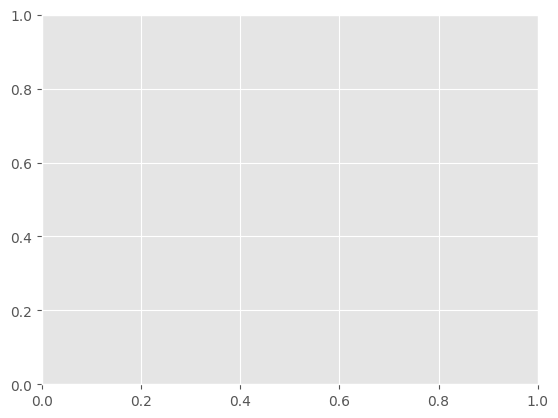

In [5]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

## Evaluating

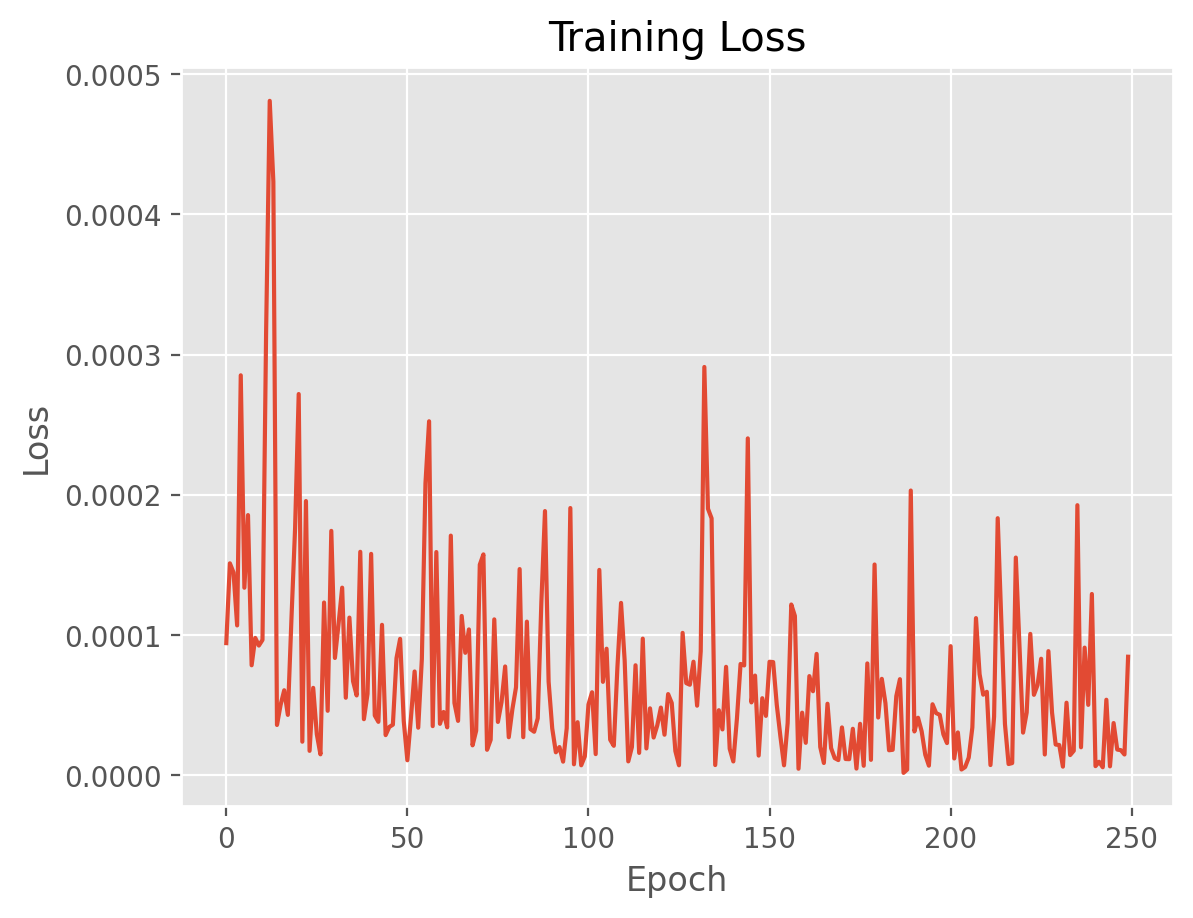

In [6]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

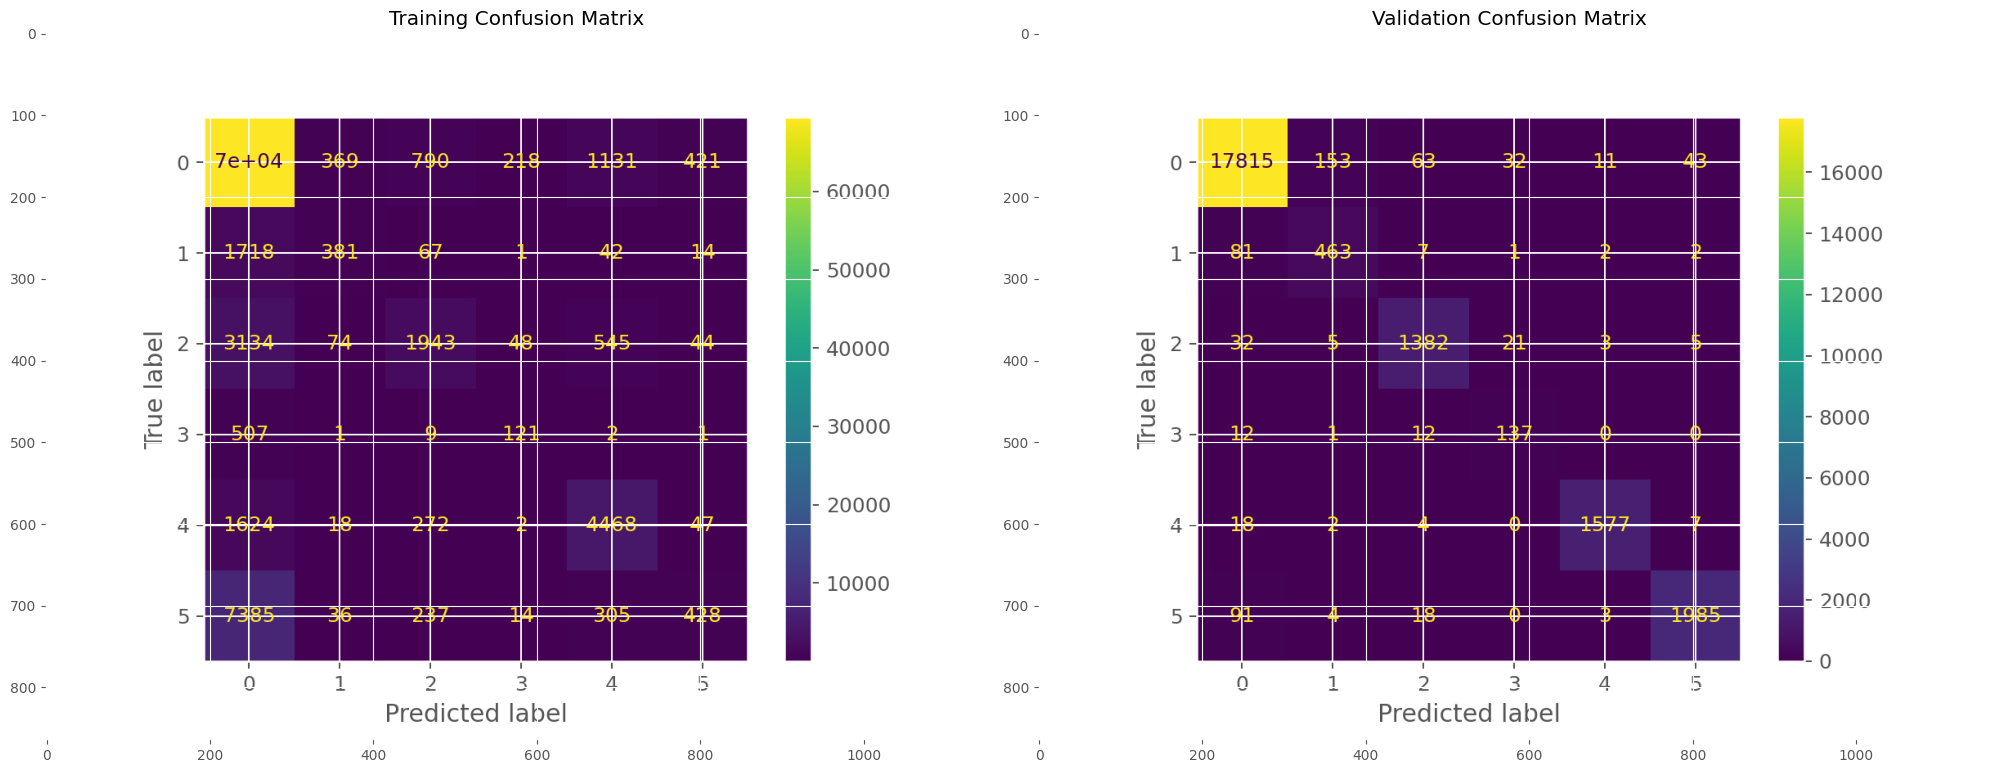

In [7]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


### Save model and load model

In [8]:
import torch
torch.save(model, "..\\model_save\\model.pth")
model_test = torch.load("..\\model_save\\model.pth")
print(model_test)

ECGformer(
  (encoder): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): Linear(in_features=192, out_features=192, bias=True)
            (values_projection): Linear(in_features=192, out_features=192, bias=True)
            (keys_projection): Linear(in_features=192, out_features=192, bias=True)
            (final_projection): Linear(in_features=192, out_features=192, bias=True)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (0): Linear(in_features=192, out_features=768, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=768, out_features=192, bias=True)
          )
          (2):